<a href="https://colab.research.google.com/github/momenashra/Algorithms/blob/main/Time_series_analysis_using_LSTM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/CYSHIELD_TASK.csv")  # Replace with the actual file name


In [4]:
df.head()

quantity  UnitePrice  discount                  date  retail price  \
0        33        16.0      20.0  2021-10-29T03:33:52Z          16.0   
1        30        16.0      20.0  2021-10-23T12:29:27Z          16.0   
2         2        45.0      30.0  2021-08-03T09:14:16Z          45.0   
3         3        16.0       3.0  2021-08-17T09:00:50Z          16.0   
4         1        45.0      27.0  2021-09-06T19:57:02Z          45.0   

  product_name          area   city  
0    product y        Bahary  North  
1    product y  Dar El-Salam  Cairo  
2    product z         Miamy  North  
3    product y         Miamy  North  
4    product z         Miamy  North

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
# Sort the DataFrame by 'Date'
df = df.sort_values(by='date')
# Set 'Date' as the index
df.set_index('date', inplace=True)

In [6]:
df.head()

quantity  UnitePrice  discount  retail price product_name  \
date                                                                    
2021-03-31         5       102.0      33.0         102.0   product x    
2021-04-30         1        16.0       9.0          16.0    product y   
2021-05-08        10        16.0       9.0          16.0    product y   
2021-05-08        10        45.0      22.0          45.0    product z   
2021-05-22        10        16.0      20.0          16.0    product y   

                   area   city  
date                            
2021-03-31  El-Mokattam  Cairo  
2021-04-30    Ain Shams  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-22        Bakos  North

In [7]:
# df['total price'] = df['UnitePrice'] * df['quantity']

In [8]:
df.describe()

quantity   UnitePrice     discount  retail price
count  2995.000000  2995.000000  2995.000000   2995.000000
mean      7.705509    60.555426    25.917225     59.615776
std     100.466019    35.270286    14.124298     36.944778
min       1.000000    10.000000    -1.000000      0.000000
25%       2.000000    16.000000    20.000000     16.000000
50%       3.000000    45.000000    31.000000     45.000000
75%       5.000000    99.000000    33.000000     99.000000
max    5000.000000   102.000000   561.000000    102.000000


*   obviously there is outilers in data since max is far from
3rd quantile in quantity and discount .
*   if discount here is percentage we must impute any row with discount > 100 .



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 2021-03-31 to 2023-01-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   retail price  2995 non-null   float64
 4   product_name  2995 non-null   object 
 5   area          2970 non-null   object 
 6   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 187.2+ KB


In [10]:
df.isnull().sum()  # Shows the count of missing values per column

quantity         0
UnitePrice       0
discount         0
retail price     0
product_name     0
area            25
city             0
dtype: int64

In [11]:
area_frequency = df['area'].value_counts()
area_frequency
#not icluding nan

area
El-Agamy           301
El-Seyouf          300
Nasr City          272
Sidy Bishr         158
El-Sheikh Zayed    151
                  ... 
Helwan               1
Al Sulaimaniyah      1
Marsa Matrouh        1
Shibin El-Kom        1
Al-Khusus            1
Name: count, Length: 70, dtype: int64

Get realation between two categorical features .

In [12]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['area'], df['city'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0

In [13]:
df.drop(columns=['area'], inplace=True)

area is not importatnt feature since it doesn't effect our forecasting for each city and highly correlated with city feature (p=0) .

In [23]:
columns_to_check = ['quantity', 'UnitePrice', 'discount', 'retail price']
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact
def detect_outliers_iqr(column, tolerance=18):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - tolerance * IQR
    upper_bound = Q3 + tolerance * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
outliers_dict = {}
# here i replaced standard 1.5 with bigger tolarance to preserve sufficient amout of data >
# with 1.5 as the tolerance value our data was only around 750 rows and with 5 around 2250 .
for col in columns_to_check :
    outliers = detect_outliers_iqr(df[col])
    outliers_dict[col] = outliers.tolist()
    df_filtered = df_filtered[~df_filtered.index.isin(outliers.index)]



In [24]:
outliers_dict

{'quantity': [100,
  1000,
  5000,
  2000,
  100,
  200,
  232,
  100,
  200,
  60,
  100,
  100,
  100,
  100,
  100,
  60],
 'UnitePrice': [],
 'discount': [561.0],
 'retail price': []}

In [25]:
columns_to_check= ['UnitePrice','retail price','discount']
# Collect indices of rows to be dropped
rows_to_drop = []

# Iterate over each row using index and row content
for index, row in df_filtered[columns_to_check].iterrows():
    # Check if any value in the row is less than or equal to 0
     if (row[['UnitePrice', 'retail price']] <= 0).any() or row['discount'] < 0:
        # Add the index to the list of rows to be dropped
        rows_to_drop.append(index)

# Drop all collected rows at once
df_filtered.drop(index=rows_to_drop, inplace=True)

In [26]:
df_filtered.describe()

quantity   UnitePrice     discount  retail price
count  2250.000000  2250.000000  2250.000000   2250.000000
mean      4.509778    60.418333    25.468387     61.328778
std       6.161322    35.105540    10.454228     36.138879
min       1.000000    10.000000     0.000000     11.000000
25%       2.000000    16.000000    20.000000     16.000000
50%       3.000000    45.000000    31.000000     45.000000
75%       5.000000    99.000000    33.000000     99.000000
max      50.000000   102.000000   100.000000    102.000000

In [27]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 2021-03-31 to 2023-01-17
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2250 non-null   int64  
 1   UnitePrice    2250 non-null   float64
 2   discount      2250 non-null   float64
 3   retail price  2250 non-null   float64
 4   product_name  2250 non-null   object 
 5   city          2250 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 123.0+ KB


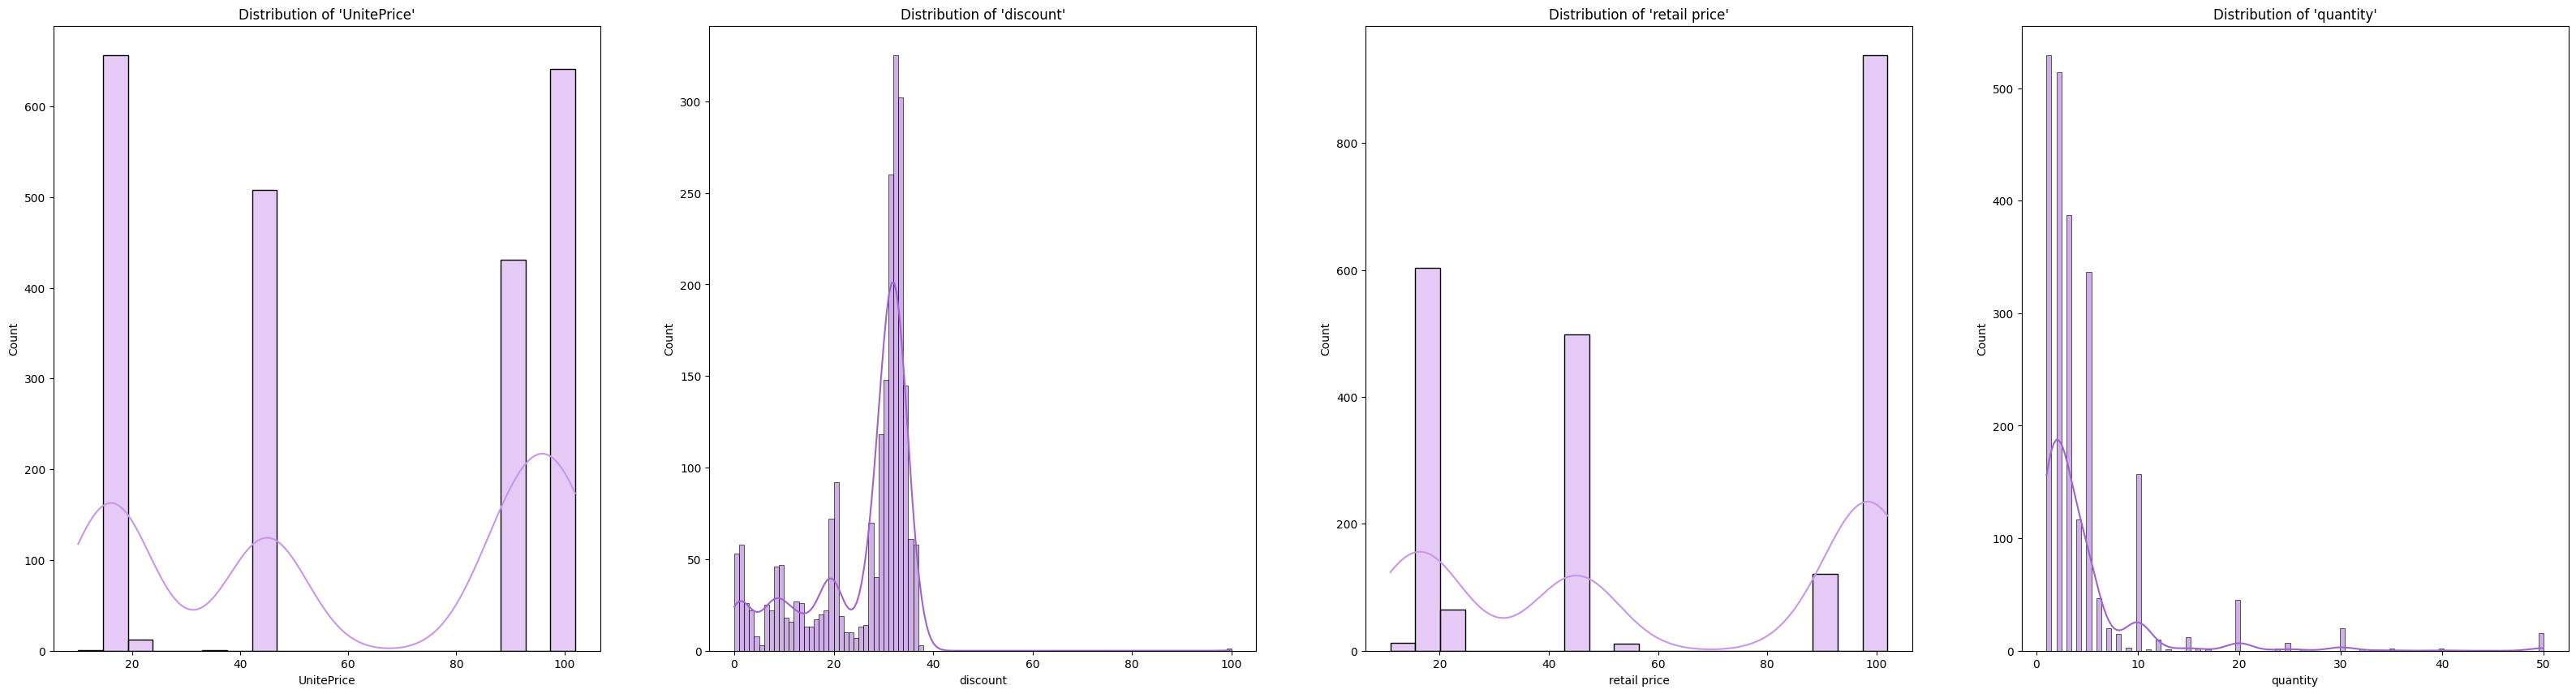

In [28]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df_filtered["UnitePrice"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df_filtered["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");
sns.histplot(ax = axes[2], x = df_filtered["retail price"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'retail price'");

sns.histplot(ax = axes[3], x = df_filtered["quantity"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'quantity'");


non of the columns looks normally distrbuted .

<Axes: xlabel='date', ylabel='quantity'>

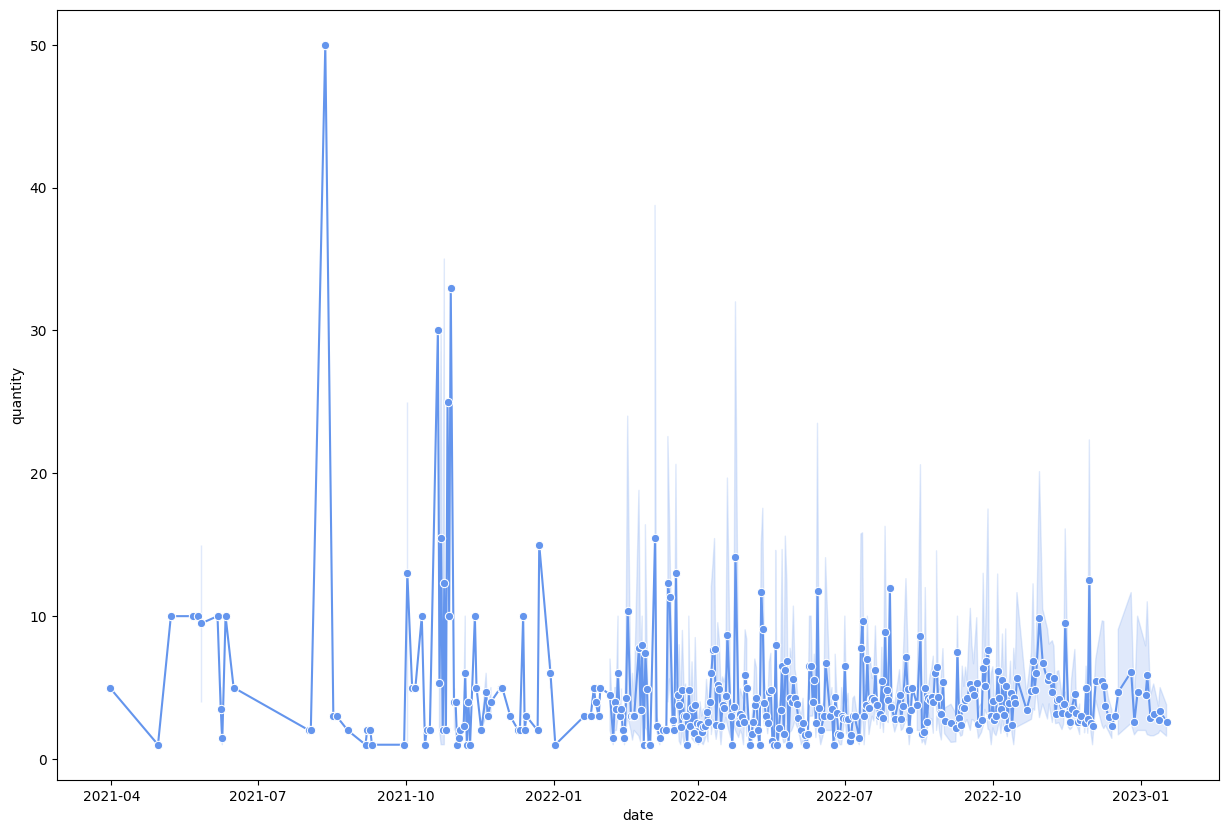

In [29]:
### Visualize time series ###
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.lineplot(x=df_filtered.index, y=df_filtered["quantity"], color='cornflowerblue', marker='o')


In [58]:
# Create a pivot table to see data more clearly and make some relation with categorical data
pivot_df = df_filtered.pivot_table(
    index='date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount', 'retail price'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index to turn 'Date' back into a column if needed
pivot_df.reset_index(inplace=True)


In [41]:
pivot_df

date  UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
0    2021-03-31                        102.0                         0.0   
1    2021-04-30                          0.0                         0.0   
2    2021-05-08                          0.0                         0.0   
3    2021-05-22                          0.0                         0.0   
4    2021-05-25                          0.0                         0.0   
..          ...                          ...                         ...   
336  2023-01-07                         99.0                       297.0   
337  2023-01-09                        297.0                       396.0   
338  2023-01-12                          0.0                        99.0   
339  2023-01-13                          0.0                        99.0   
340  2023-01-17                          0.0                        99.0   

     UnitePrice_product x _North  UnitePrice_product y_Cairo  \
0                            0.0                         0.0   
1                            0.0                        16.0   
2                            0.0                        16.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
..                           ...                         ...   
336                        693.0                         0.0   
337                          0.0                         0.0   
338                        396.0                        16.0   
339                        198.0                         0.0   
340                        396.0                         0.0   

     UnitePrice_product y_Giza  UnitePrice_product y_North  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                        16.0   
4                          0.0                        16.0   
..                         ...                         ...   
336                       32.0                         0.0   
337                        0.0                        16.0   
338                        0.0                        16.0   
339                        0.0                         0.0   
340                        0.0                         0.0   

     UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                          45.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
..                          ...                        ...   
336                         0.0                        0.0   
337                         0.0                        0.0   
338                        45.0                        0.0   
339                         0.0                        0.0   
340                         0.0                        0.0   

     UnitePrice_product z_North  ...  quantity_product z_North  \
0                           0.0  ...                         0   
1                           0.0  ...                         0   
2                           0.0  ...                         0   
3                           0.0  ...                         0   
4                           0.0  ...                         0   
..                          ...  ...                       ...   
336                       135.0  ...                         5   
337                         0.0  ...                         0   
338                        90.0  ...                         7   
339                         0.0  ...                         0   
340                         0.0  ...                         0   

     retail price_product x _Cairo  retail pri

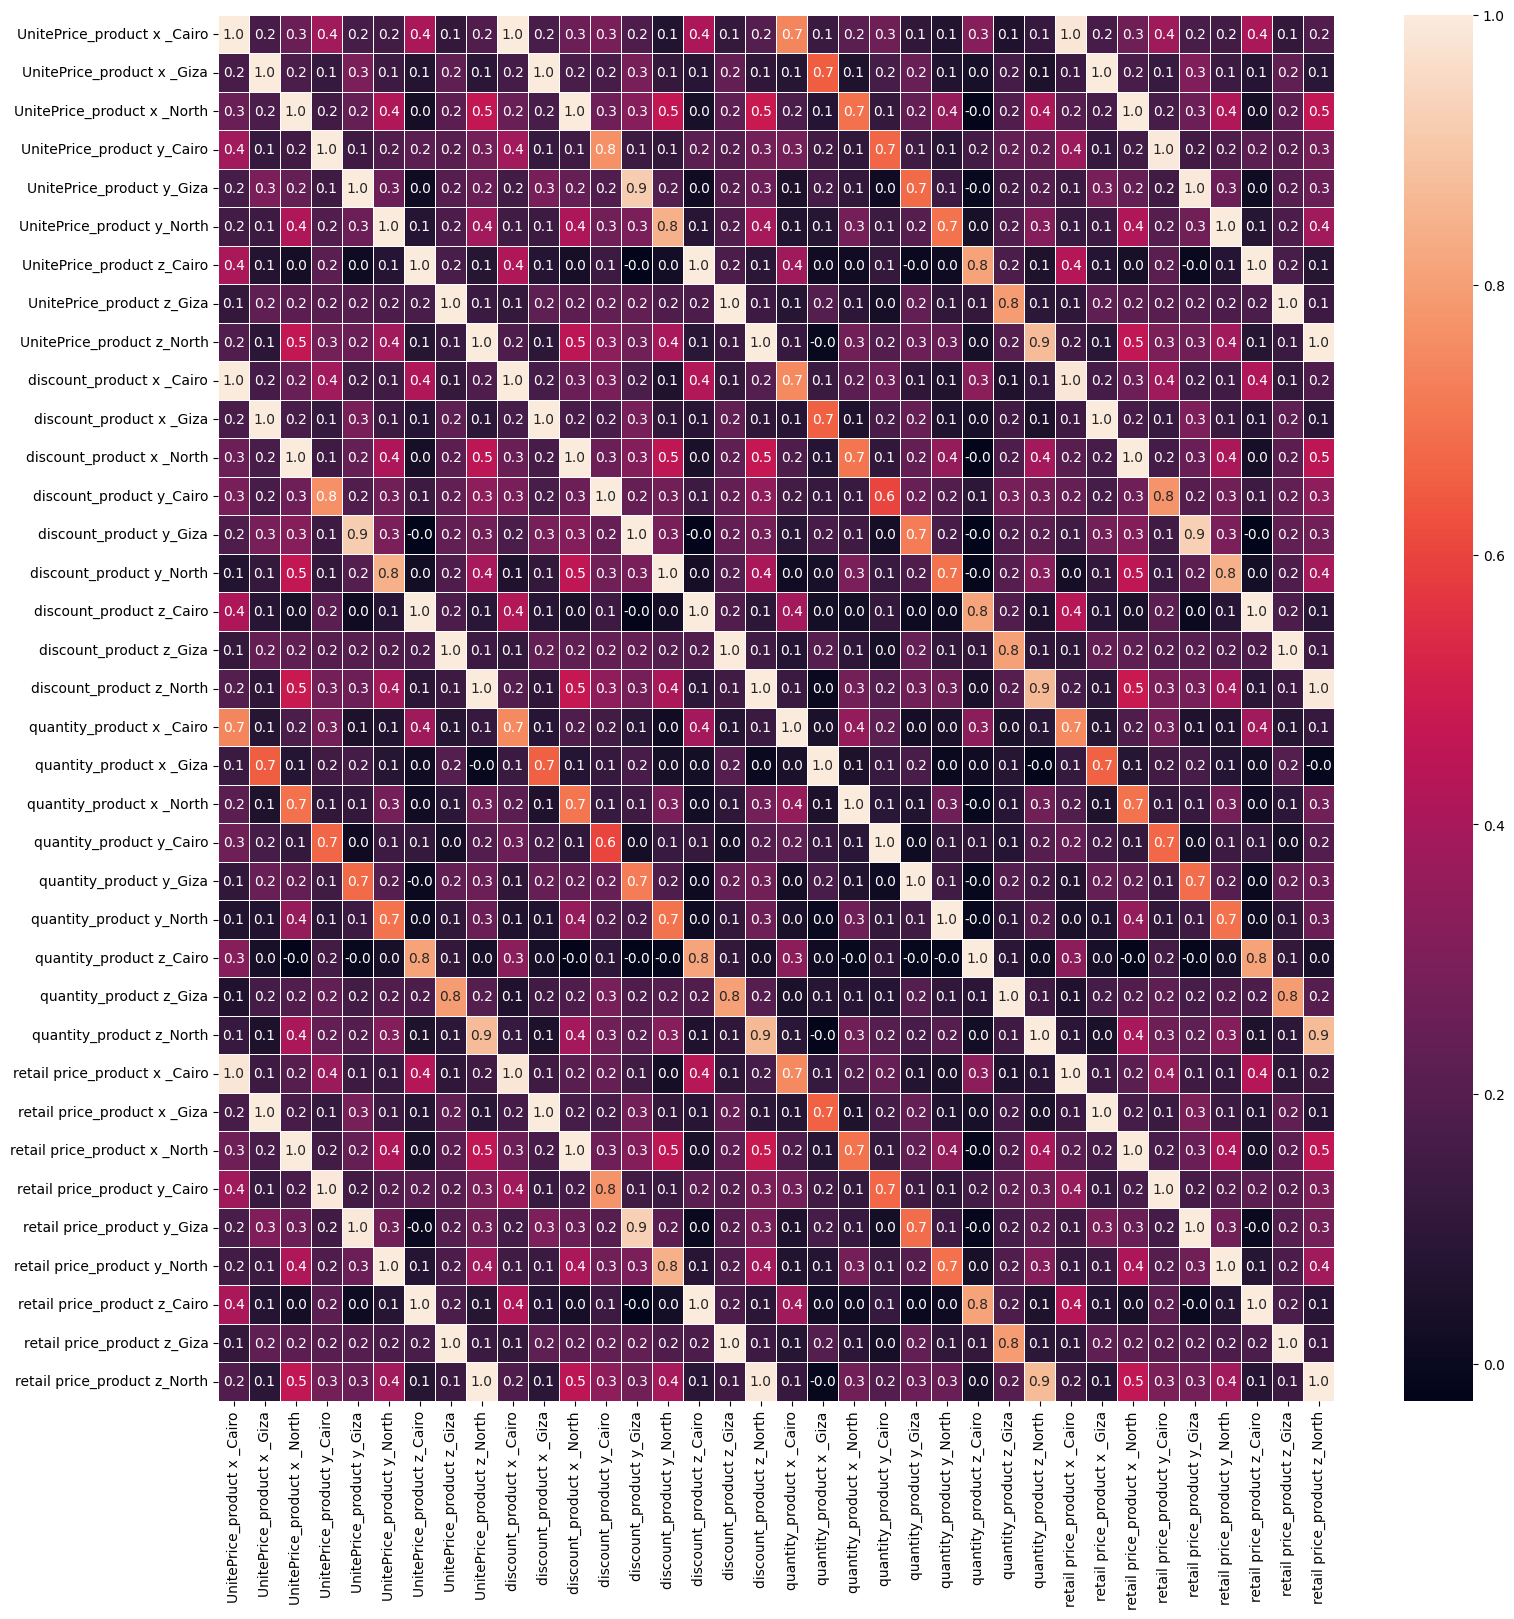

In [31]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pivot_df.drop(columns=['date']).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

*no significant correlations out of diagonal.*

In [32]:
# Select specific columns from pivot DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
       'quantity_product x _North', 'quantity_product y_Cairo',
       'quantity_product y_Giza', 'quantity_product y_North',
       'quantity_product z_Cairo', 'quantity_product z_Giza',
       'quantity_product z_North']

In [33]:
pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
pivot_df.index

RangeIndex(start=0, stop=341, step=1)

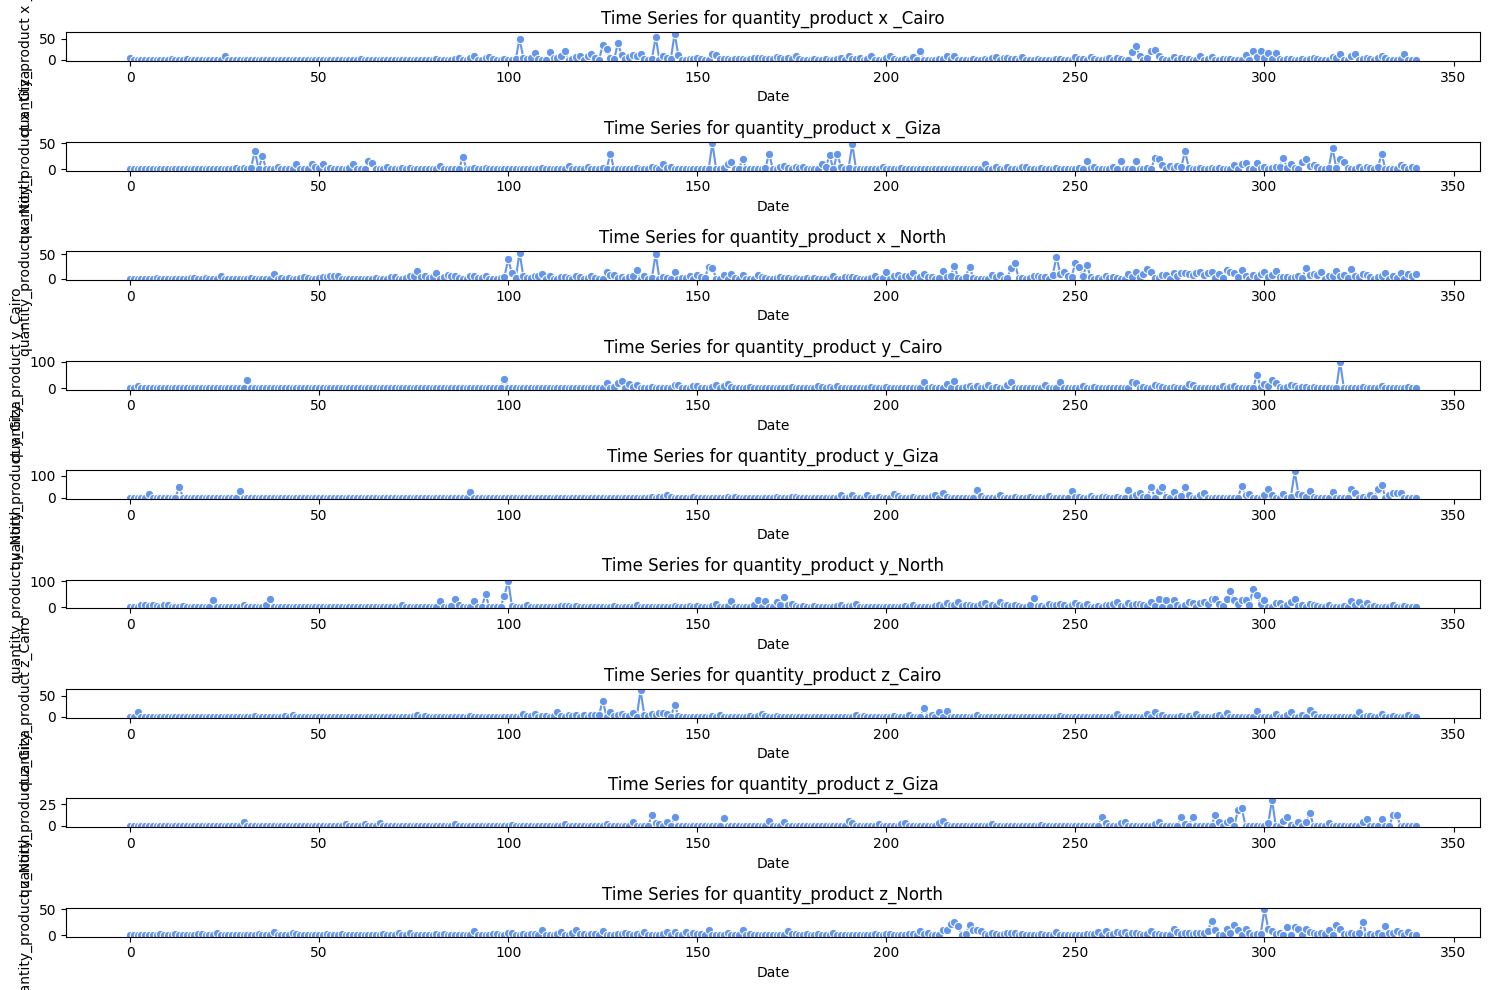

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with as many subplots as the number of out_cols
fig, ax = plt.subplots(nrows=len(out_cols), ncols=1, figsize=(15, 10))
# Loop over your target columns (out_cols) and create one plot for each
for i in range(len(out_cols)):
    sns.lineplot(x=pivot_df.index, y=pivot_df[out_cols[i]], ax=ax[i], color='cornflowerblue', marker='o')
    ax[i].set_title(f"Time Series for {out_cols[i]}")
    ax[i].set_xlabel('Date')
    # ax[i].set_ylabel(out_cols[i])

# Adjust layout to ensure plots are spaced properly
plt.tight_layout()

# Display the plot
plt.show()


In [38]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [39]:
# Step 1: Check for Stationarity using ADF test
def test_stationarity(series):
    result = adfuller(series)
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Test for stationarity on each column (assuming each column is a time series)
for column in pivot_df[out_cols]:
    print(f"Testing stationarity for {column}")
    test_stationarity(pivot_df[column])


Testing stationarity for quantity_product x _Cairo
p-value: 3.3961131865764214e-05
Series is stationary
Testing stationarity for quantity_product x _Giza
p-value: 2.8209514690362886e-30
Series is stationary
Testing stationarity for quantity_product x _North
p-value: 6.722574439955189e-07
Series is stationary
Testing stationarity for quantity_product y_Cairo
p-value: 6.927286646921416e-30
Series is stationary
Testing stationarity for quantity_product y_Giza
p-value: 0.0007400980907808499
Series is stationary
Testing stationarity for quantity_product y_North
p-value: 0.0017741401237725452
Series is stationary
Testing stationarity for quantity_product z_Cairo
p-value: 0.09928252009830846
Series is not stationary
Testing stationarity for quantity_product z_Giza
p-value: 0.17884328559865548
Series is not stationary
Testing stationarity for quantity_product z_North
p-value: 0.0429388596072761
Series is stationary


In [96]:
pivot_df_weekly=pivot_df.copy()
pivot_df_weekly['date'] = pd.to_datetime(pivot_df_weekly['date'])
pivot_df_weekly.set_index('date', inplace=True)

# Resample to weekly frequency (or any other suitable frequency)
pivot_df_weekly = pivot_df_weekly.resample('D').mean()

# Handle missing values by interpolation (if needed)
pivot_df_weekly.interpolate(method='linear', inplace=True)

In [97]:
pivot_df_weekly

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
date                                                                  
2021-03-31                        102.0                         0.0   
2021-04-01                         98.6                         0.0   
2021-04-02                         95.2                         0.0   
2021-04-03                         91.8                         0.0   
2021-04-04                         88.4                         0.0   
...                                 ...                         ...   
2023-01-13                          0.0                        99.0   
2023-01-14                          0.0                        99.0   
2023-01-15                          0.0                        99.0   
2023-01-16                          0.0                        99.0   
2023-01-17                          0.0                        99.0   

            UnitePrice_product x _North  UnitePrice_product y_Cairo  \
date                                                                  
2021-03-31                          0.0                    0.000000   
2021-04-01                          0.0                    0.533333   
2021-04-02                          0.0                    1.066667   
2021-04-03                          0.0                    1.600000   
2021-04-04                          0.0                    2.133333   
...                                 ...                         ...   
2023-01-13                        198.0                    0.000000   
2023-01-14                        247.5                    0.000000   
2023-01-15                        297.0                    0.000000   
2023-01-16                        346.5                    0.000000   
2023-01-17                        396.0                    0.000000   

            UnitePrice_product y_Giza  UnitePrice_product y_North  \
date                                                                
2021-03-31                        0.0                         0.0   
2021-04-01                        0.0                         0.0   
2021-04-02                        0.0                         0.0   
2021-04-03                        0.0                         0.0   
2021-04-04                        0.0                         0.0   
...                               ...                         ...   
2023-01-13                        0.0                         0.0   
2023-01-14                        0.0                         0.0   
2023-01-15                        0.0                         0.0   
2023-01-16                        0.0                         0.0   
2023-01-17                        0.0                         0.0   

            UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
date                                                                
2021-03-31                         0.0                        0.0   
2021-04-01                         0.0                        0.0   
2021-04-02                         0.0                        0.0   
2021-04-03                         0.0                        0.0   
2021-04-04                         0.0                        0.0   
...                                ...                        ...   
2023-01-13                         0.0                        0.0   
2023-01-14                         0.0                        0.0   
2023-01-15                         0.0                        0.0   
2023-01-16                         0.0                        0.0   
2023-01-17                         0.0                        0.0   

            UnitePrice_product z_North  discount_product x _Cairo  ...  \
date                                                               ...   
2021-03-31                         0.0                       33.0  ...   
2021-04-01                         0.0                       31.9  ...   
2021-04-02                         0.0                       30.8  ...  

most features are not stationary .

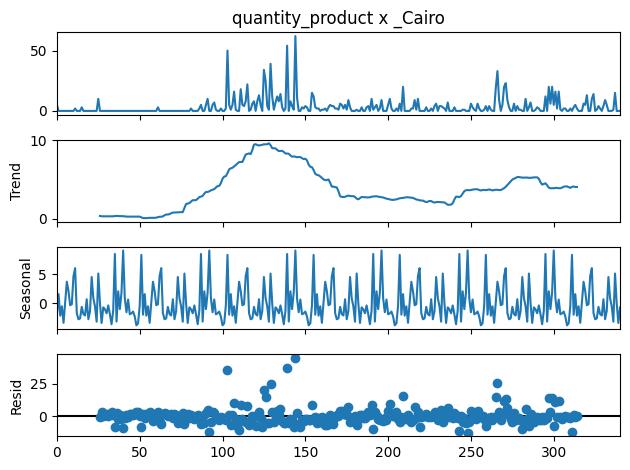

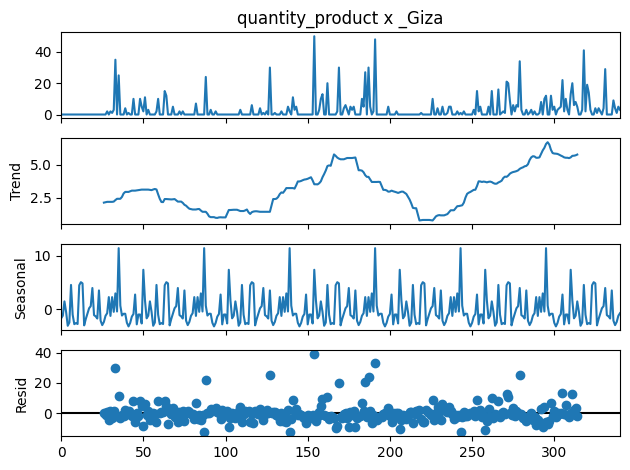

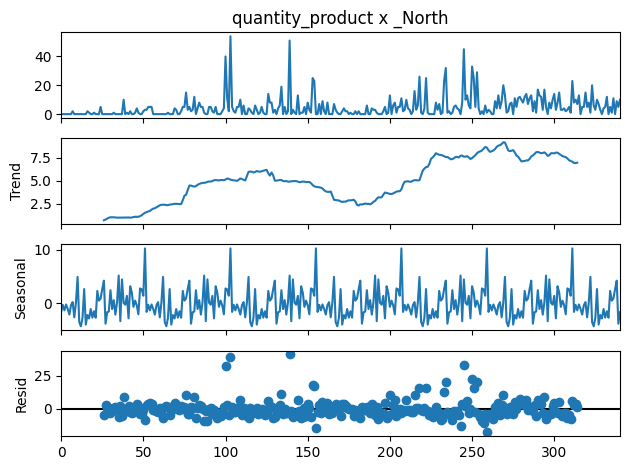

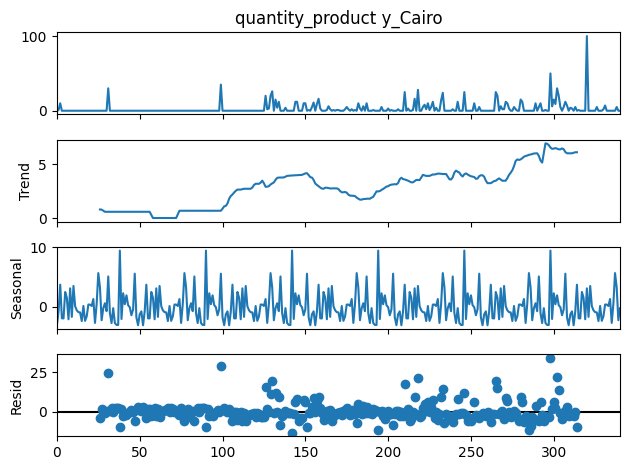

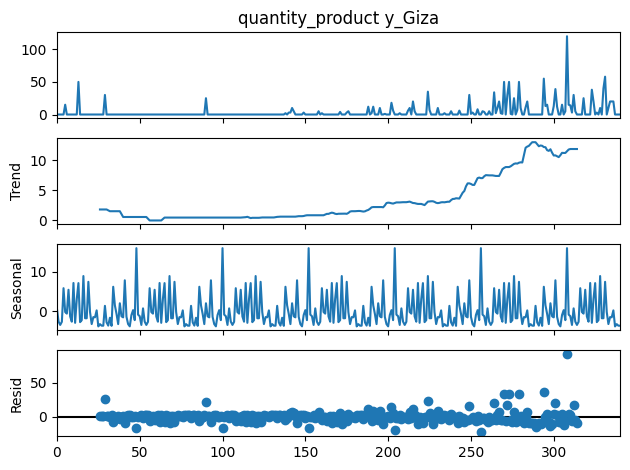

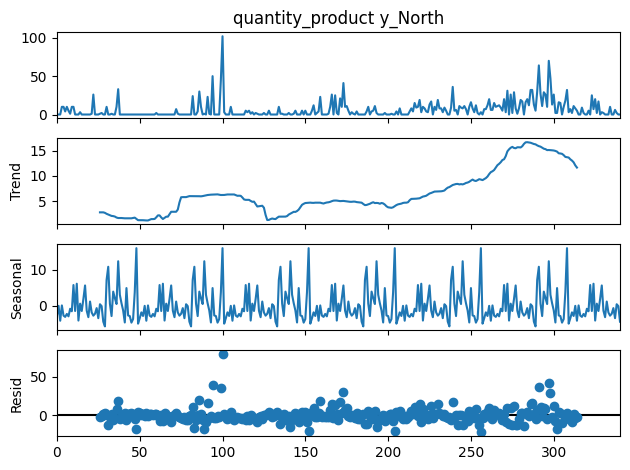

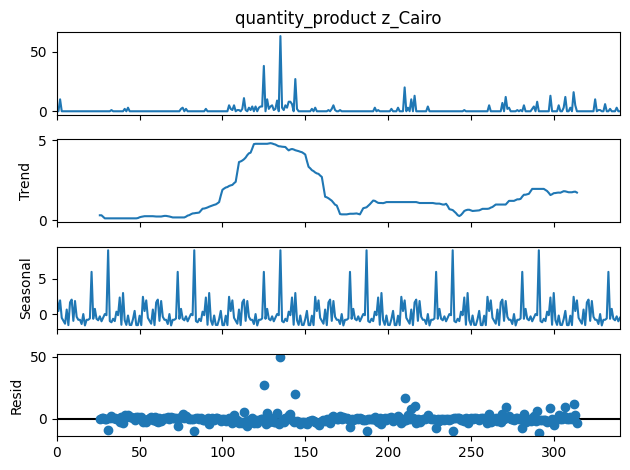

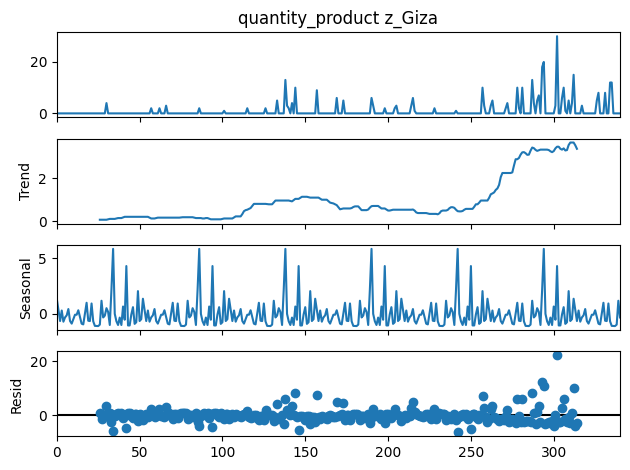

In [98]:
def decompose_time_series(series):
    decomposition = seasonal_decompose(series, model='additive', period=52)
    decomposition.plot()
    plt.show()

# Decompose the first column to visualize seasonality
for i in range (19 , 27 , 1) :
  decompose_time_series(pivot_df.iloc[:, i])


# **data is non stationary and have seasonal component .**

try SARIMAX model .


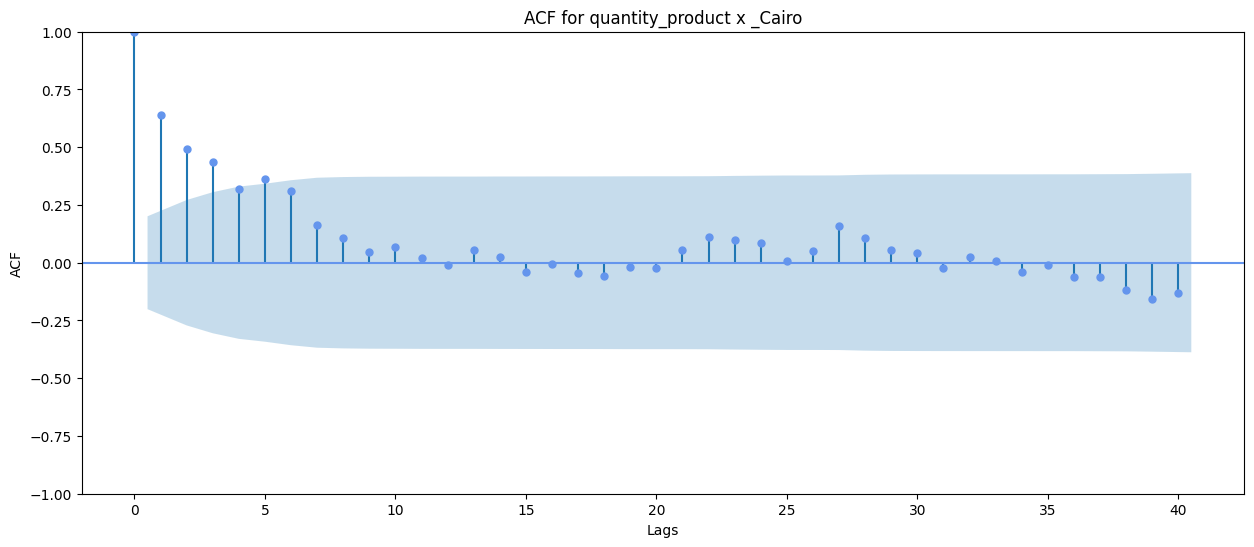

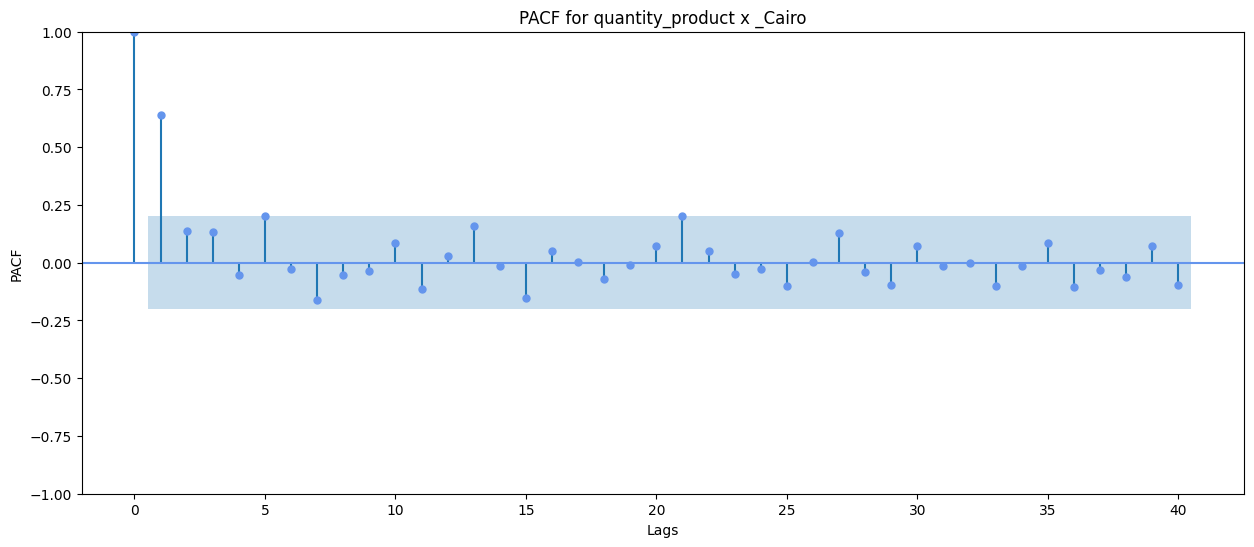

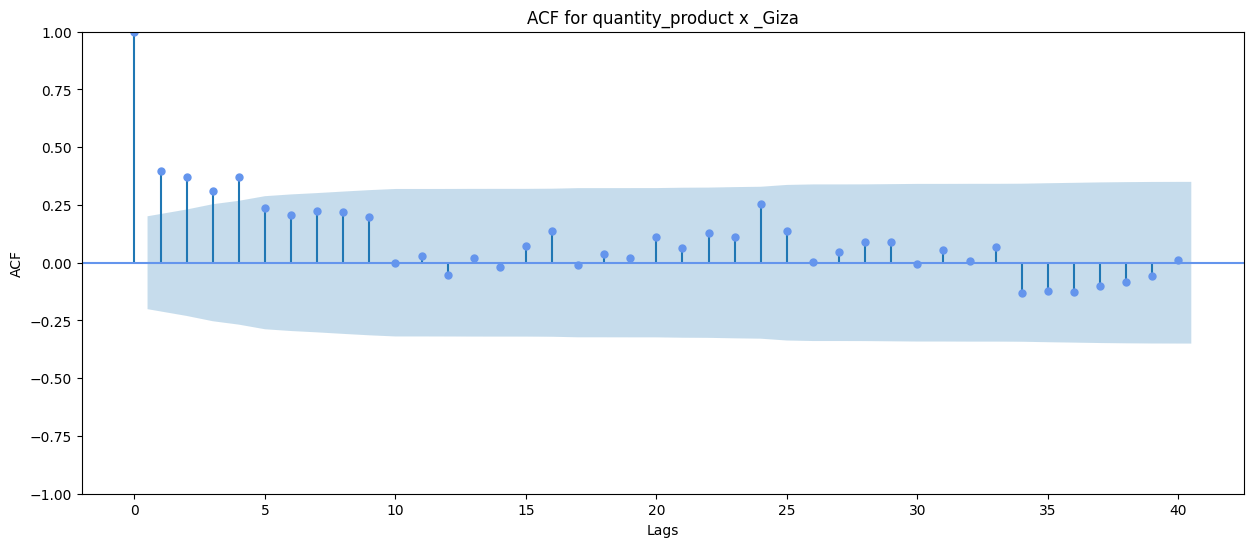

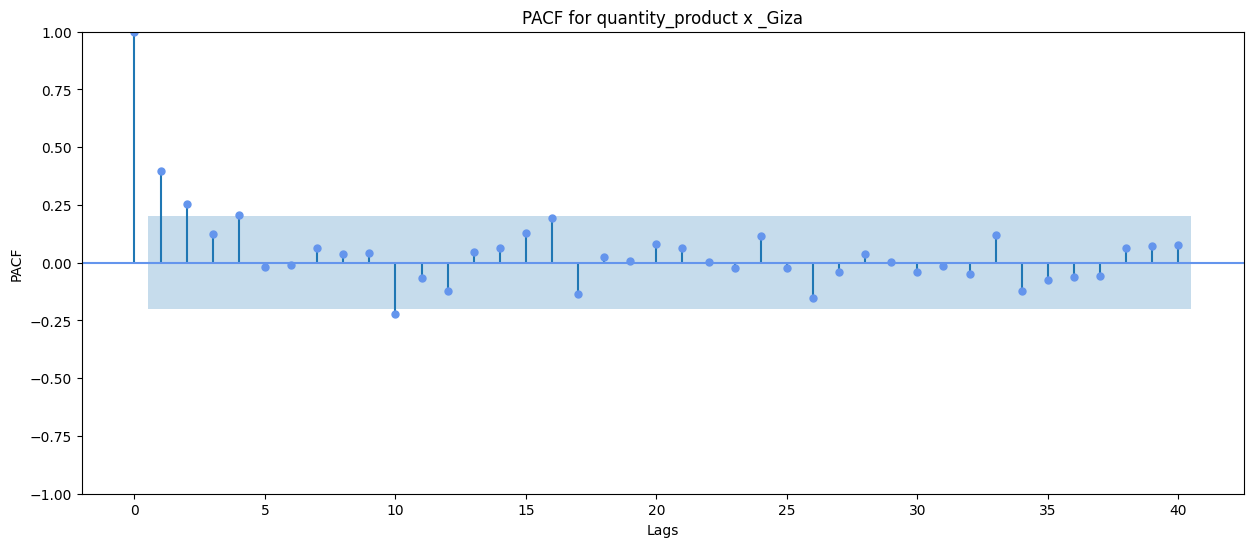

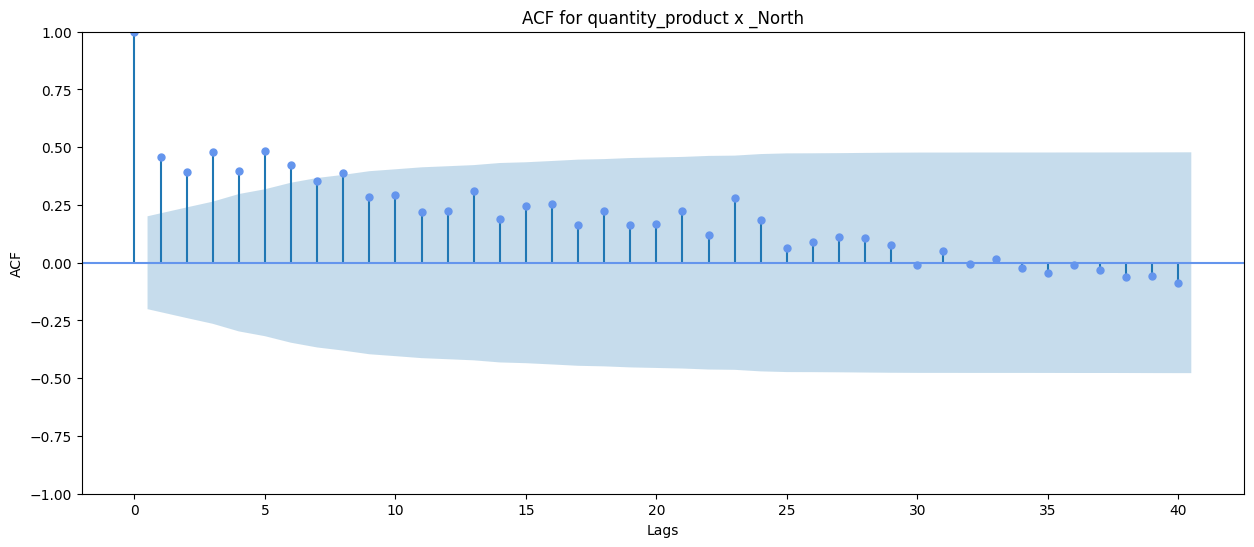

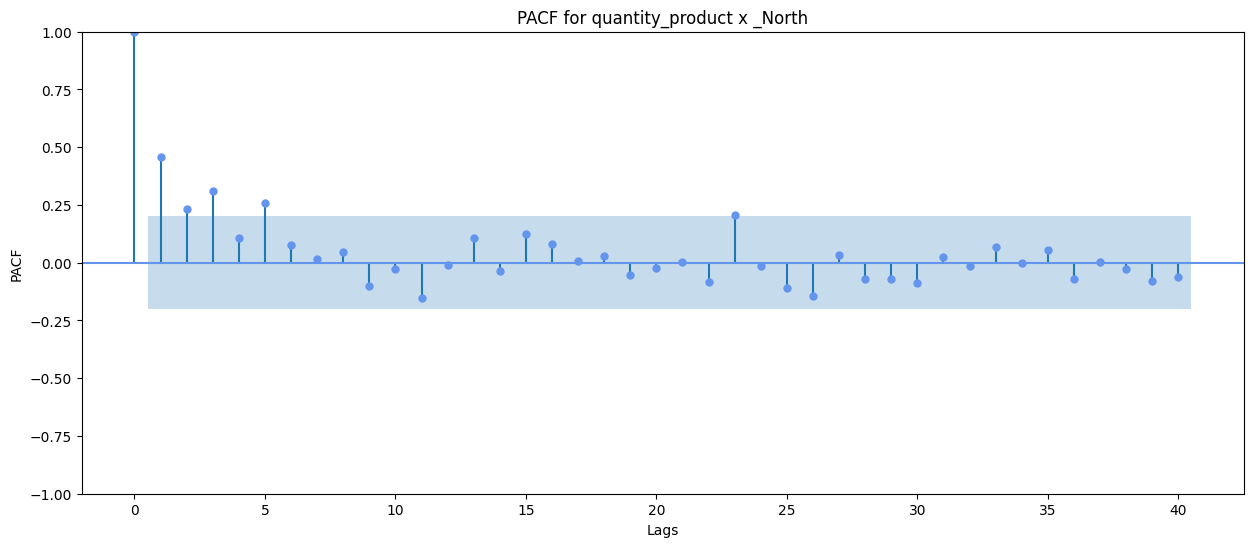

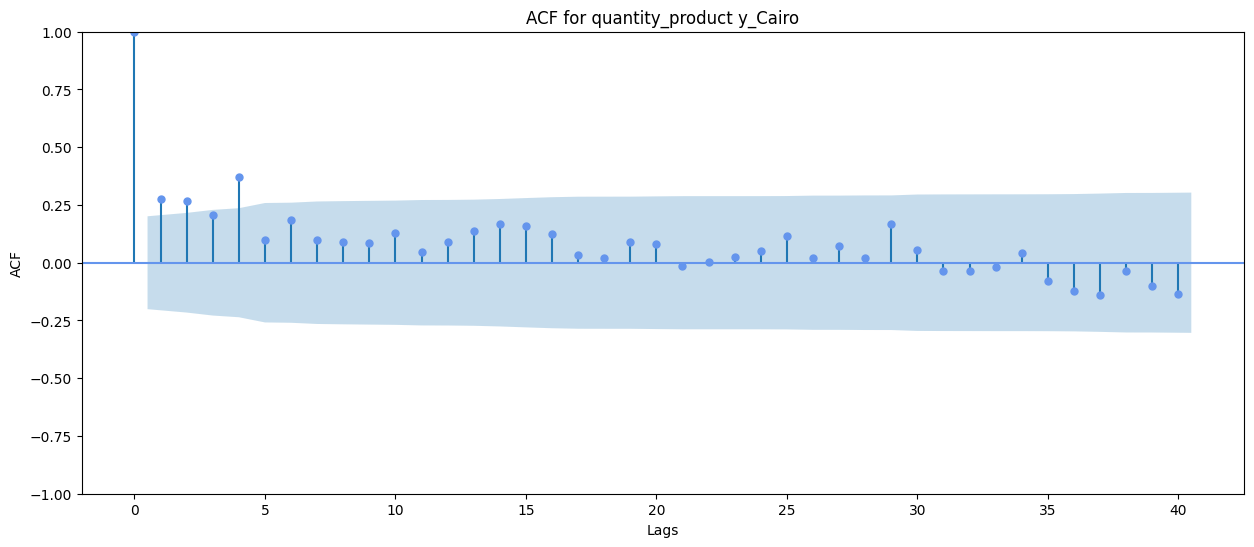

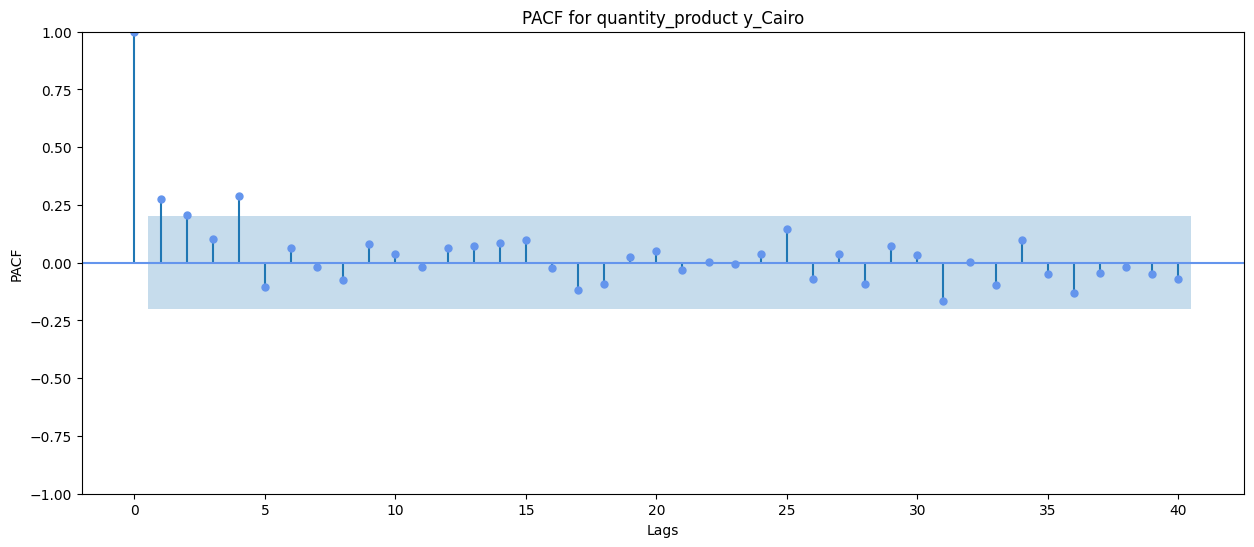

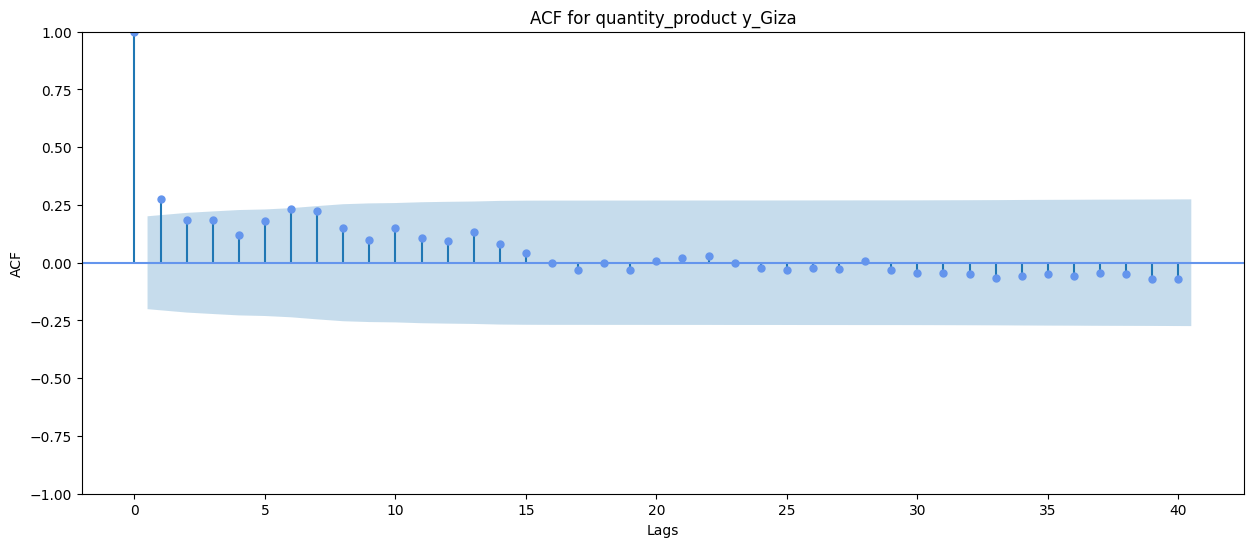

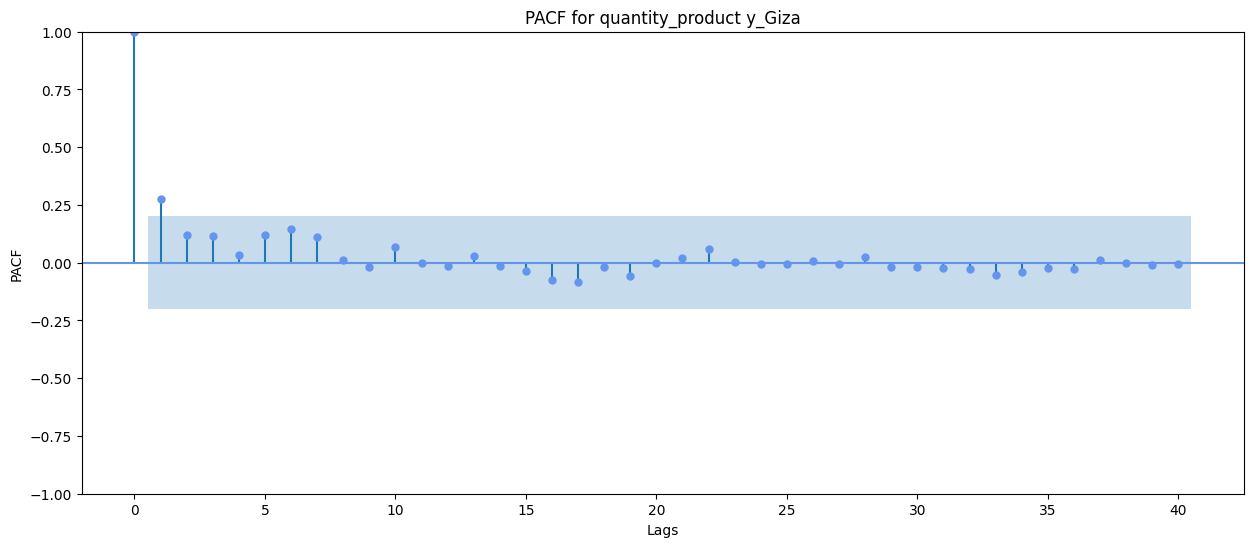

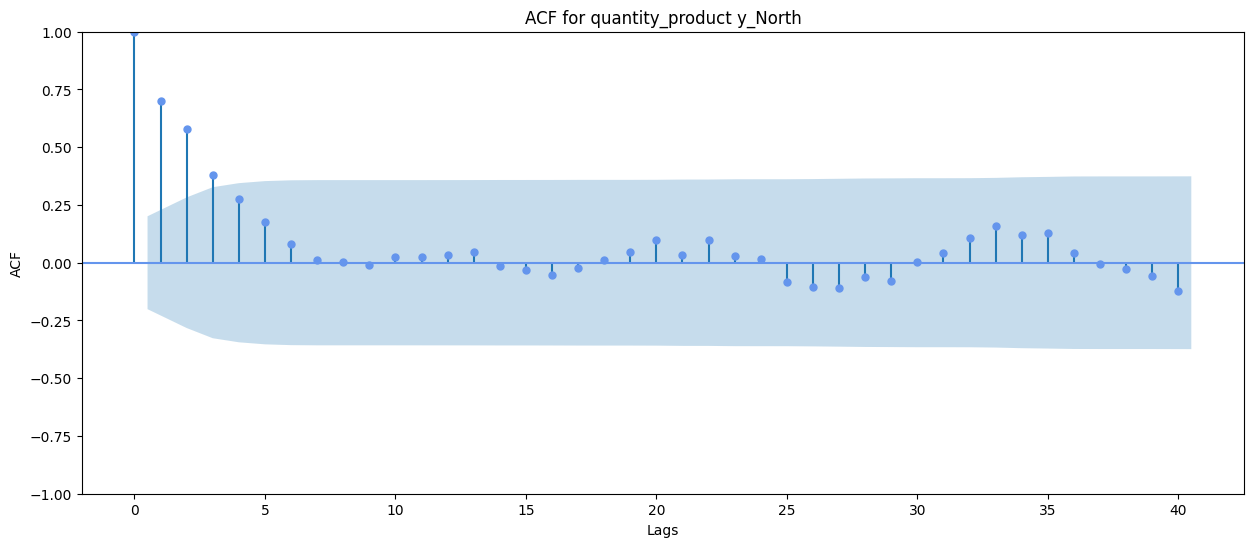

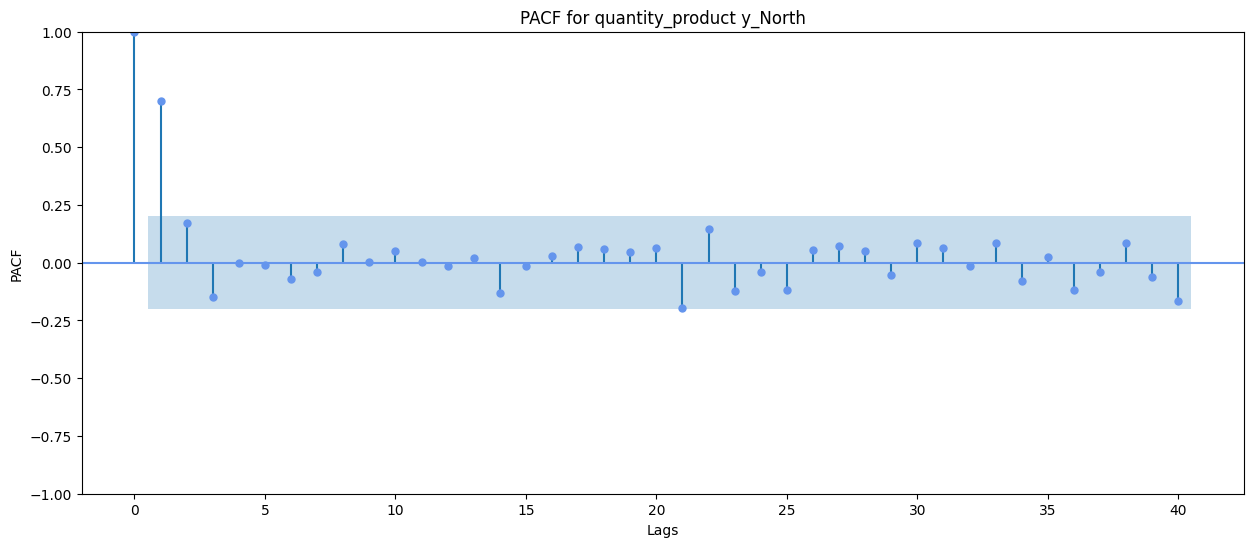

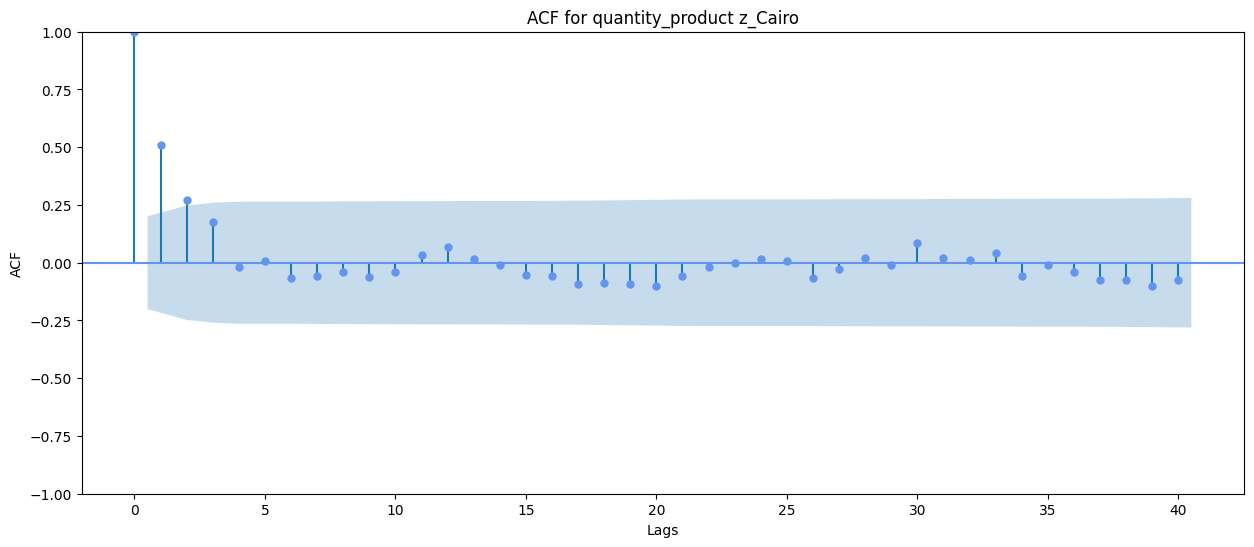

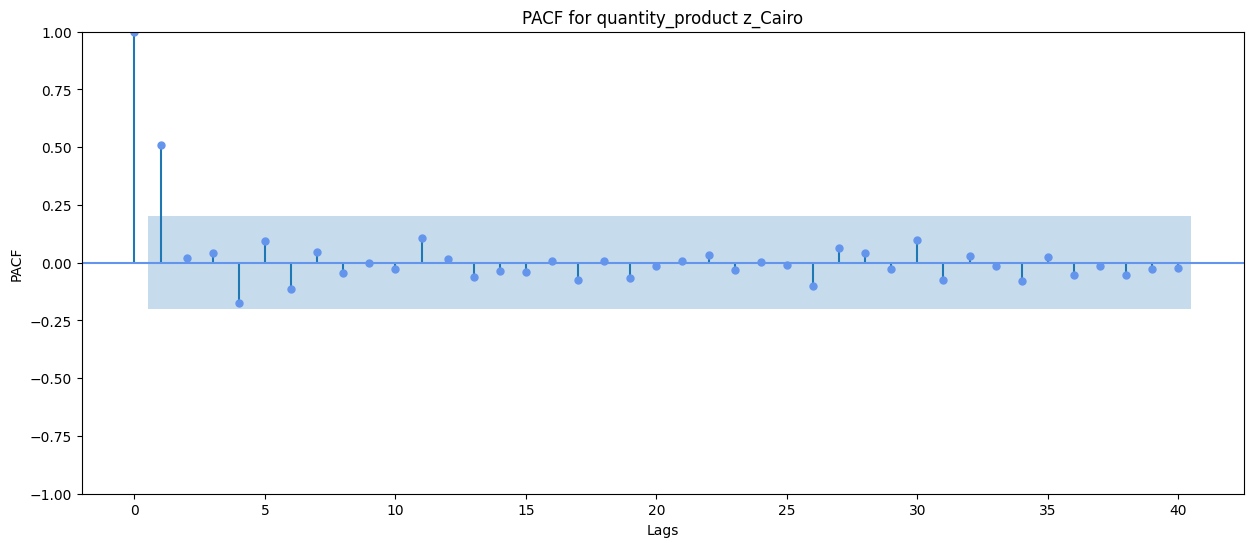

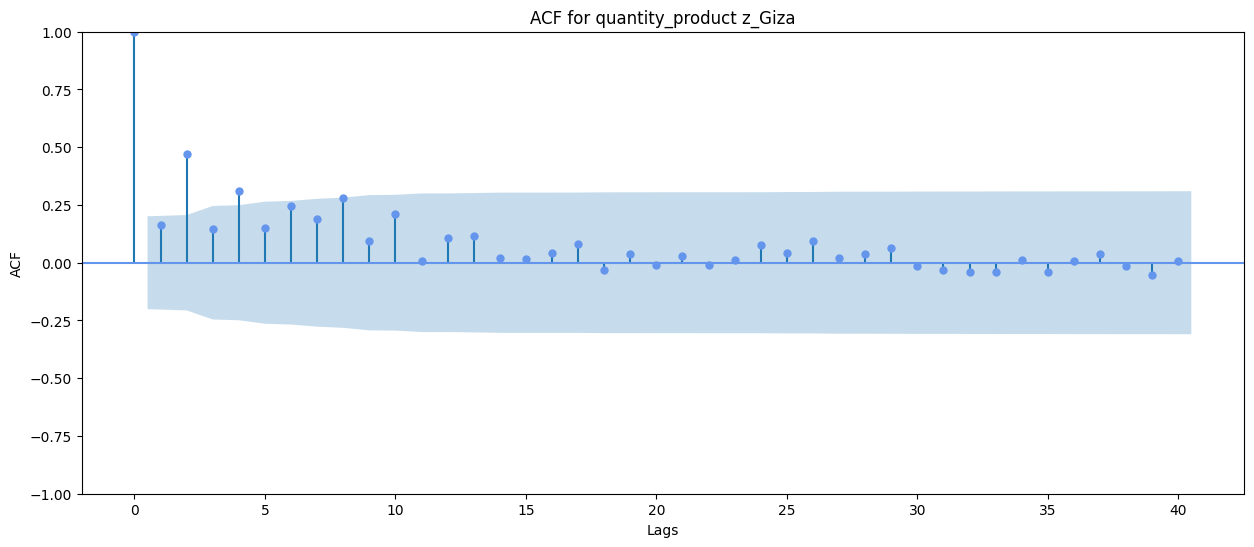

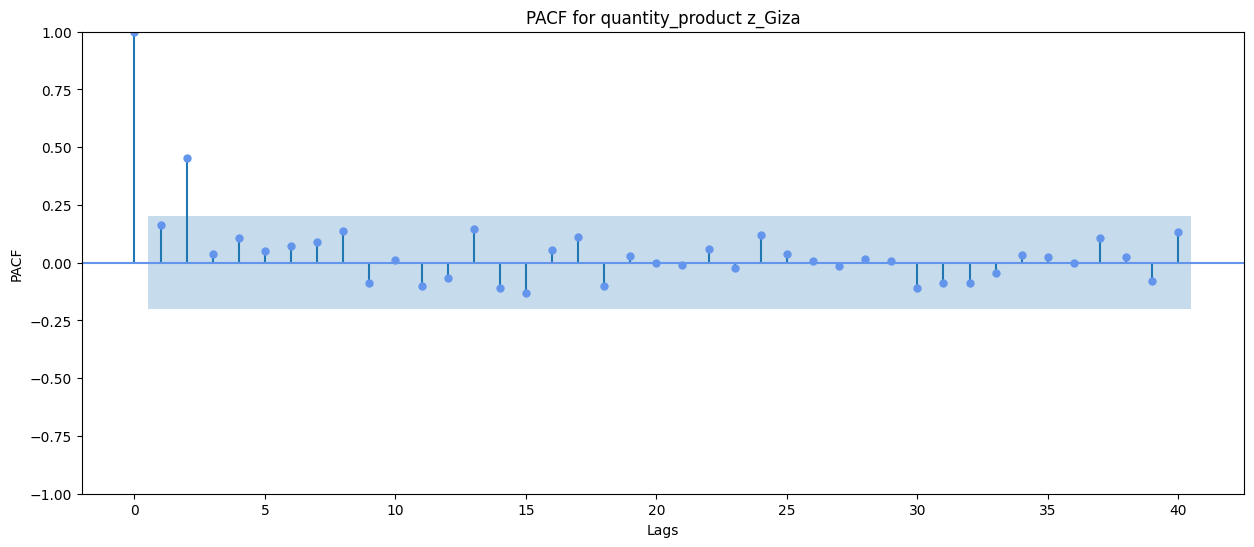

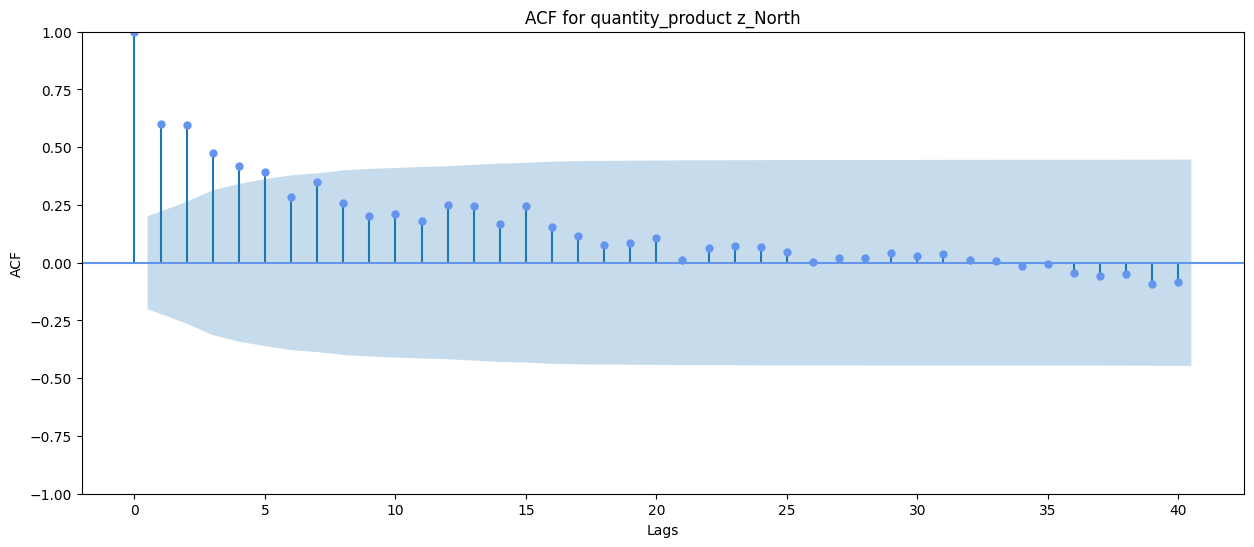

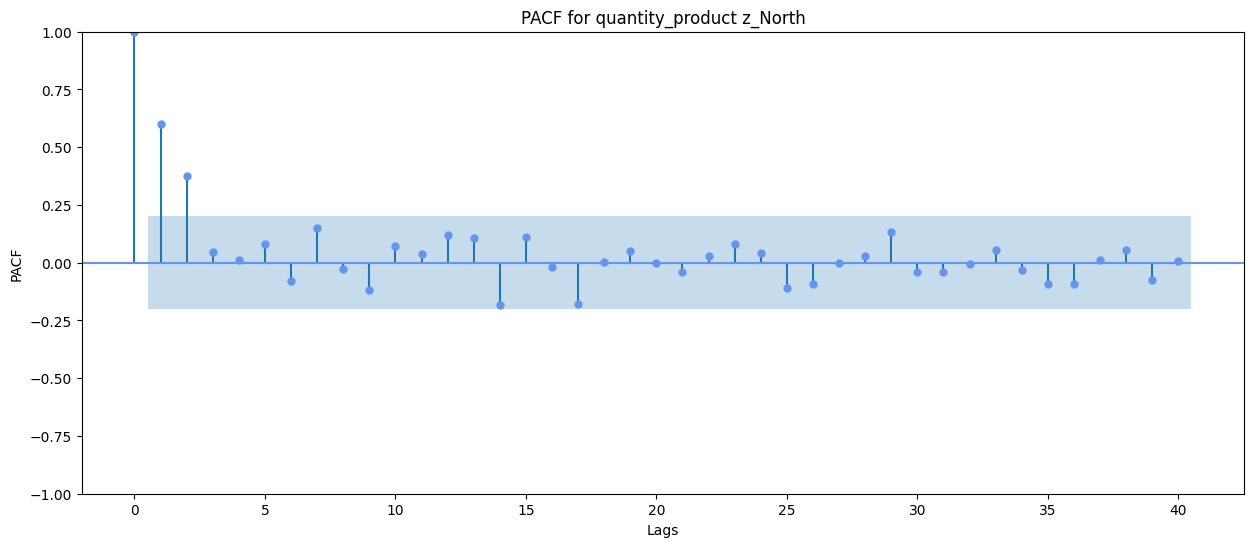

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Loop through your target columns and plot ACF and PACF
for col in out_cols:
    # Plot ACF
    plt.figure(figsize=(15, 6))
    plot_acf(pivot_df_weekly[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'ACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(15, 6))
    plot_pacf(pivot_df_weekly[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'PACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results for quantity_product x _Cairo:
                                   SARIMAX Results                                   
Dep. Variable:     quantity_product x _Cairo   No. Observations:                   76
Model:                      SARIMAX(5, 1, 3)   Log Likelihood                -147.425
Date:                       Tue, 21 Jan 2025   AIC                            312.851
Time:                               12:52:31   BIC                            333.087
Sample:                           04-04-2021   HQIC                           320.889
                                - 09-11-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3356      0.805     -1.660      0.097      -2.913       0.242
ar.L2         -0.5238      1.482    

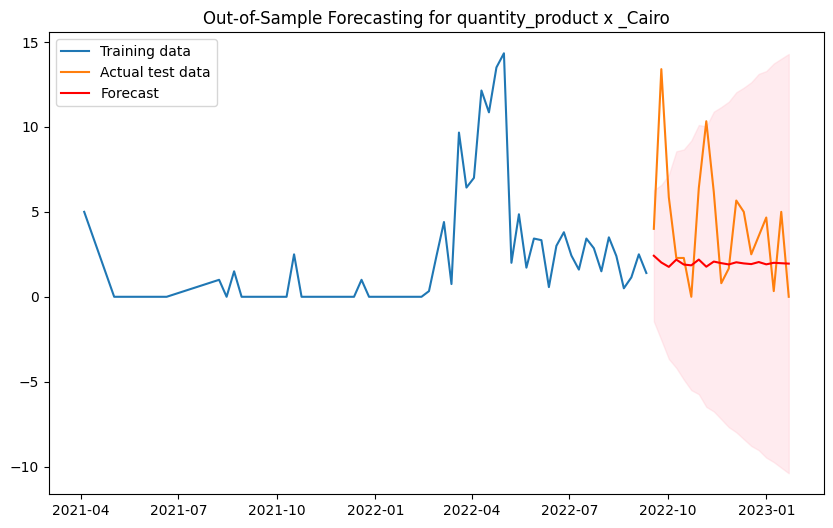

Results for quantity_product x _Giza:
                                  SARIMAX Results                                   
Dep. Variable:     quantity_product x _Giza   No. Observations:                   76
Model:                     SARIMAX(5, 1, 3)   Log Likelihood                -164.066
Date:                      Tue, 21 Jan 2025   AIC                            346.132
Time:                              12:52:32   BIC                            366.368
Sample:                          04-04-2021   HQIC                           354.170
                               - 09-11-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8509      0.688     -1.237      0.216      -2.199       0.498
ar.L2          0.1000      0.618      0.162  

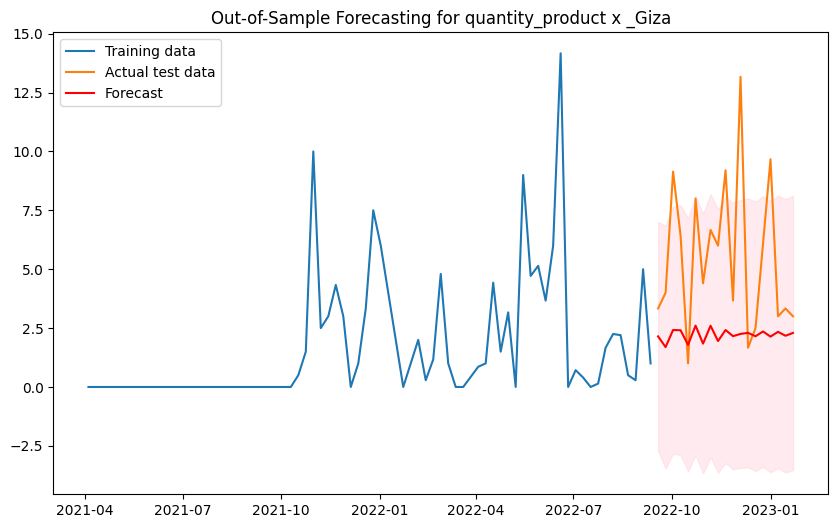

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results for quantity_product x _North:
                                   SARIMAX Results                                   
Dep. Variable:     quantity_product x _North   No. Observations:                   76
Model:                      SARIMAX(5, 1, 3)   Log Likelihood                -181.052
Date:                       Tue, 21 Jan 2025   AIC                            380.104
Time:                               12:52:33   BIC                            400.340
Sample:                           04-04-2021   HQIC                           388.142
                                - 09-11-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0703      1.855     -0.577      0.564      -4.706       2.566
ar.L2         -1.1136      1.969    

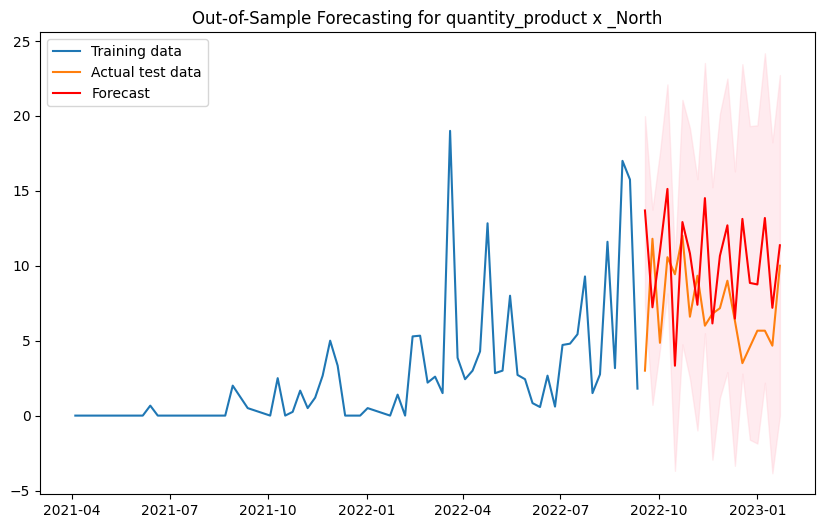

Results for quantity_product y_Cairo:
                                  SARIMAX Results                                   
Dep. Variable:     quantity_product y_Cairo   No. Observations:                   76
Model:                     SARIMAX(5, 1, 3)   Log Likelihood                -152.779
Date:                      Tue, 21 Jan 2025   AIC                            323.559
Time:                              12:52:34   BIC                            343.795
Sample:                          04-04-2021   HQIC                           331.597
                               - 09-11-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6744      0.593     -1.138      0.255      -1.836       0.488
ar.L2         -0.5395      0.522     -1.034  

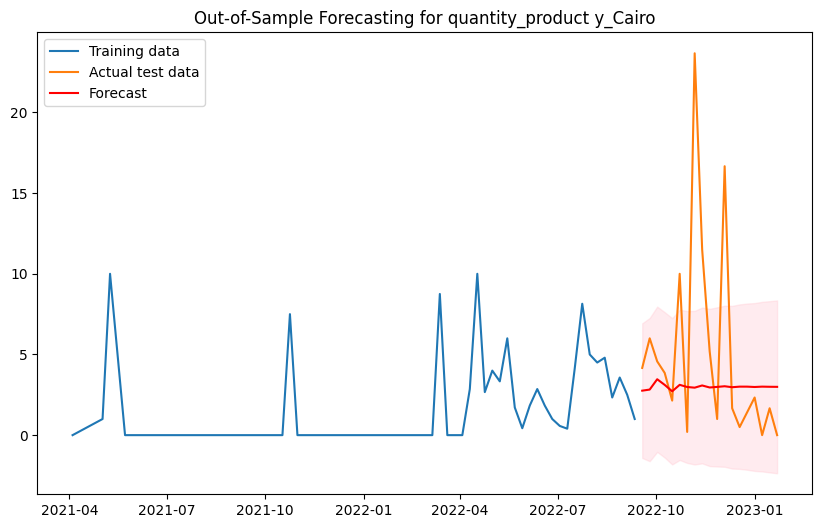

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results for quantity_product y_Giza:
                                  SARIMAX Results                                  
Dep. Variable:     quantity_product y_Giza   No. Observations:                   76
Model:                    SARIMAX(5, 1, 3)   Log Likelihood                -225.468
Date:                     Tue, 21 Jan 2025   AIC                            468.936
Time:                             12:52:35   BIC                            489.172
Sample:                         04-04-2021   HQIC                           476.974
                              - 09-11-2022                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3360      1.267     -0.265      0.791      -2.819       2.147
ar.L2         -0.9064      0.392     -2.309      0.021

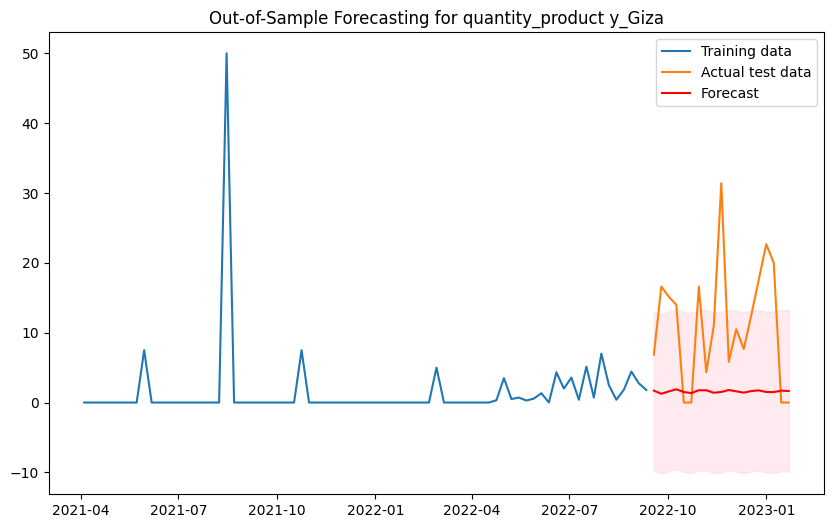

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results for quantity_product y_North:
                                  SARIMAX Results                                   
Dep. Variable:     quantity_product y_North   No. Observations:                   76
Model:                     SARIMAX(5, 1, 3)   Log Likelihood                -195.048
Date:                      Tue, 21 Jan 2025   AIC                            408.095
Time:                              12:52:36   BIC                            428.332
Sample:                          04-04-2021   HQIC                           416.133
                               - 09-11-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6723      0.742      0.906      0.365      -0.781       2.126
ar.L2          0.1379      0.812      0.170  

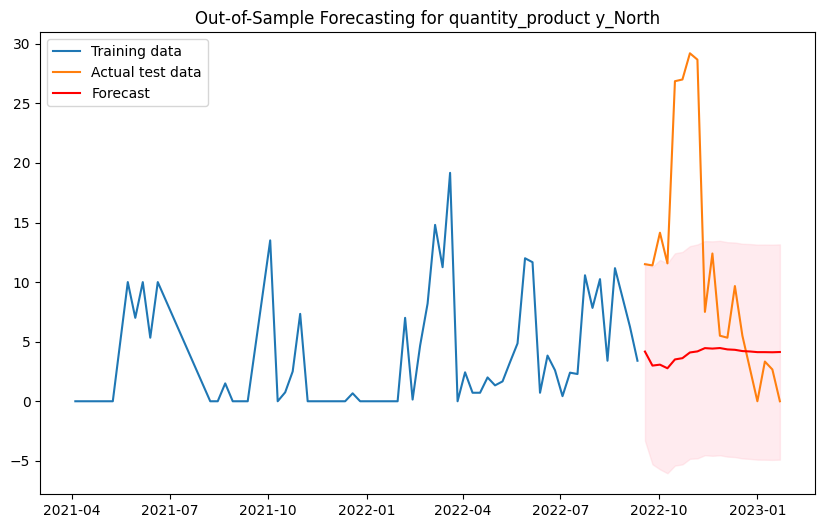

Results for quantity_product z_Cairo:
                                  SARIMAX Results                                   
Dep. Variable:     quantity_product z_Cairo   No. Observations:                   76
Model:                     SARIMAX(5, 1, 3)   Log Likelihood                -136.732
Date:                      Tue, 21 Jan 2025   AIC                            291.464
Time:                              12:52:36   BIC                            311.701
Sample:                          04-04-2021   HQIC                           299.503
                               - 09-11-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4186      0.387     -1.081      0.280      -1.178       0.341
ar.L2          0.2110      0.206      1.024  

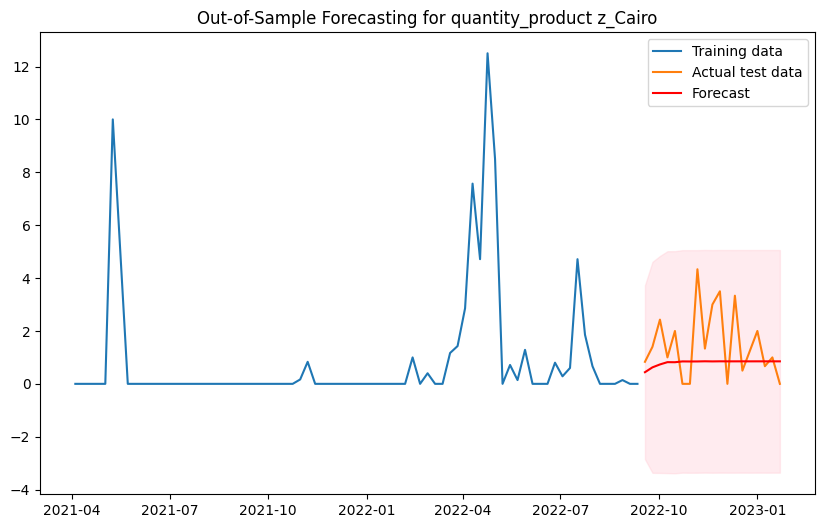

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


Results for quantity_product z_Giza:
                                  SARIMAX Results                                  
Dep. Variable:     quantity_product z_Giza   No. Observations:                   76
Model:                    SARIMAX(5, 1, 3)   Log Likelihood                 -73.436
Date:                     Tue, 21 Jan 2025   AIC                            164.872
Time:                             12:52:37   BIC                            185.108
Sample:                         04-04-2021   HQIC                           172.910
                              - 09-11-2022                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7748      0.485     -1.598      0.110      -1.725       0.176
ar.L2         -0.5064      0.410     -1.235      0.217

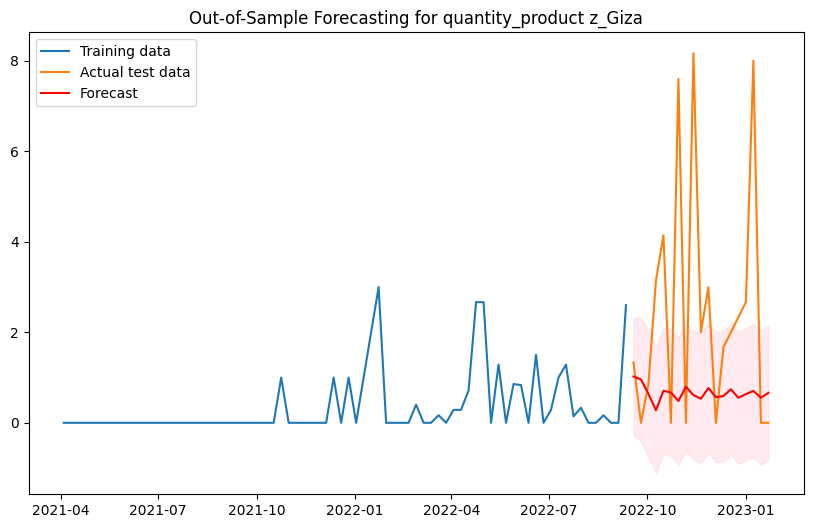

Results for quantity_product z_North:
                                  SARIMAX Results                                   
Dep. Variable:     quantity_product z_North   No. Observations:                   76
Model:                     SARIMAX(5, 1, 3)   Log Likelihood                -131.582
Date:                      Tue, 21 Jan 2025   AIC                            281.163
Time:                              12:52:37   BIC                            301.400
Sample:                          04-04-2021   HQIC                           289.202
                               - 09-11-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0236      1.665      0.014      0.989      -3.239       3.286
ar.L2          0.3599      0.582      0.619  

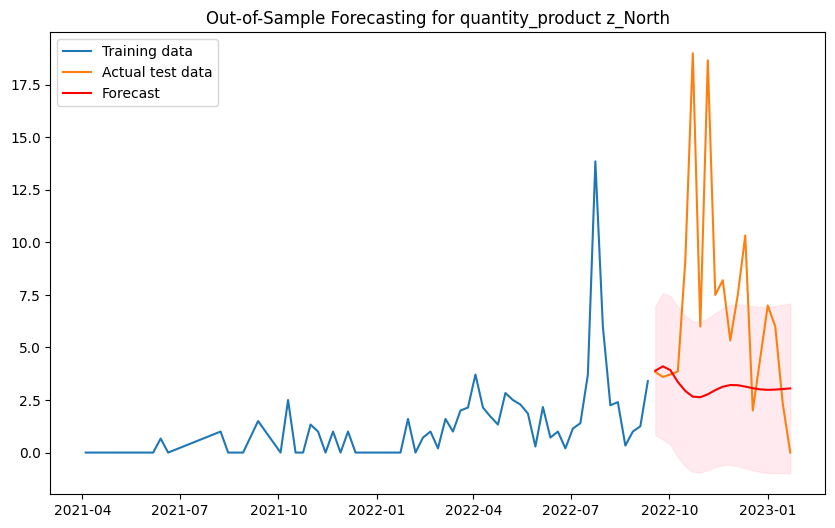

In [72]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Loop over each target column to fit a SARIMAX model
for col in out_cols:
    # Split the data into train and test sets
    train_size = int(len(pivot_df_weekly) * 0.8)  # 80% for training
    train, test = pivot_df_weekly[col][:train_size], pivot_df_weekly[col][train_size:]  # Split the data

    # Fit the SARIMAX model to the training set
    model = SARIMAX(train,
                    order=(5, 1, 3),  # ARIMA parameters (p, d, q)
                    seasonal_order=(0, 0, 0,52),  # Seasonal ARIMA parameters (P, D, Q, S)
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    model_fit = model.fit(disp=False)

    # Print the results for the model fit
    print(f"Results for {col}:")
    print(model_fit.summary())

    # Forecast the future values based on the test period
    forecast = model_fit.get_forecast(steps=len(test))  # Forecasting for the length of the test set
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Plot the forecasted values against the actual test values
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Training data')  # Plot the historical training data
    plt.plot(test.index, test, label='Actual test data')  # Plot the actual test data
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')  # Plot the forecasted values
    plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)  # Plot confidence intervals
    plt.legend()
    plt.title(f'Out-of-Sample Forecasting for {col}')
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best order (p, d, q): (5, 1, 3)
Best AIC: 1365.1525231757505


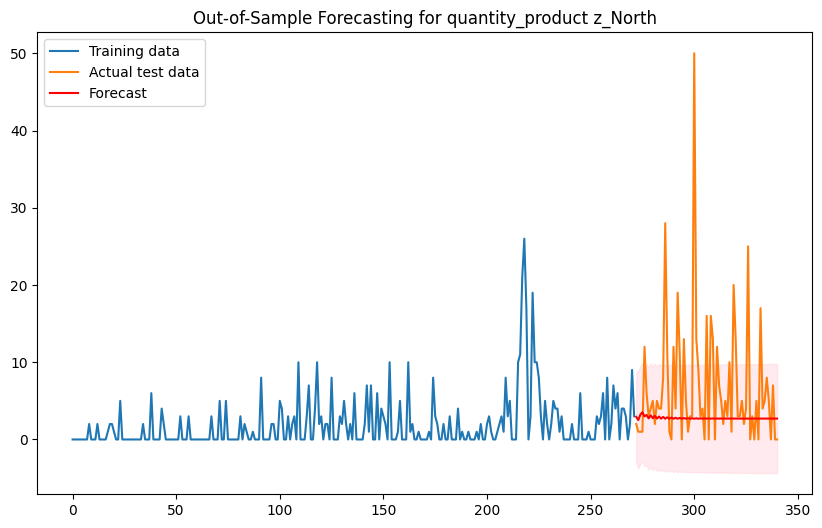

In [71]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define ranges for p, d, q
p_values = range(0, 6)  # Try values from 0 to 5 for p
d_values = range(0, 2)  # Usually 0 or 1 for differencing
q_values = range(0, 5)  # Try values from 0 to 5 for q

# Create a grid of all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = float('inf')
best_order = None
best_seasonal_order = (0, 0, 0, 52)  # Assuming yearly seasonality (S=12 for monthly data)
best_model = None

# Loop through all possible combinations of (p, d, q)
for order in pdq_combinations:
    try:
        # Split the data into train and test sets
        train_size = int(len(pivot_df) * 0.8)  # 80% for training
        train, test = pivot_df[col][:train_size], pivot_df[col][train_size:]  # Split the data

        # Fit the SARIMAX model with the current (p, d, q)
        model = SARIMAX(train,
                        order=order,  # ARIMA parameters (p, d, q)
                        seasonal_order=best_seasonal_order,  # Seasonal order (fixed here)
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=False)

        # Check AIC value for the current model
        aic = model_fit.aic

        # If this model has a lower AIC, update the best model
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit

    except Exception as e:
        print(f"Skipping {order} due to error: {e}")
        continue

# Output the best (p, d, q) combination and its corresponding AIC
print(f"Best order (p, d, q): {best_order}")
print(f"Best AIC: {best_aic}")

# Plot the forecast using the best model
forecast = best_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecasted values against the actual test values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training data')  # Plot the historical training data
plt.plot(test.index, test, label='Actual test data')  # Plot the actual test data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')  # Plot the forecasted values
plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)  # Plot confidence intervals
plt.legend()
plt.title(f'Out-of-Sample Forecasting for {col}')
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate performance metrics
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
mae = mean_absolute_error(test, forecast_mean)

# Print performance metrics
print(f"Performance Metrics for {col}:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
from sklearn.metrics import mean_squared_error
forecast = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")

In [73]:
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)


AIC: 281.16336592727885
BIC: 301.3998231057231


-----------------------------------------------------------------------------------------------------------------------------

In [95]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [99]:
y = pivot_df_weekly[out_cols]
X = pivot_df_weekly.drop(out_cols, axis=1)

In [100]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [101]:
n_steps = 10
n_features_out=9
forecast_horizon = 10  # Predict 10 days ahead

In [102]:
dataset = hstack((X,y))

# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_output_features = y.shape[2]  # Number of output features (9)

In [103]:
import datetime

# Define your reference date (e.g., 2020-01-01)
reference_date = np.datetime64('2021-03-31')

# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column (which contains datetime.date)
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

# After converting, X will have numerical days values in place of the dates


In [104]:
X

array([[[102. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 98.6,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 95.2,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [ 78.2,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 74.8,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 71.4,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[ 98.6,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 95.2,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 91.8,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [ 74.8,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 71.4,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 68. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[ 95.2,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 91.8,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 88.4,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [ 71.4,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 68. ,   0. ,   0. , ...,   0. ,   0

In [105]:
X = X.astype('float32')
y = y.astype('float32')

In [106]:
from sklearn.model_selection import train_test_split
# Assuming X and y are your input and output arrays respectively
test_size = 0.2  # 20% of the data for testing
X_test= X[-10:]
y_test= y[-10:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (511, 10, 27), y_train shape: (511, 10, 9)
X_test shape: (10, 10, 27), y_test shape: (10, 10, 9)


In [107]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (639, 10, 27)
y shape: (639, 10, 9)


In [108]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(n_output_features * forecast_horizon))  # Output layer adjusted for multi-feature output
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │           4,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,190 (78.87 KB)

 Trainable params: 20,190 (78.87 KB)

 Non-trainable params: 0 (0.00 B)

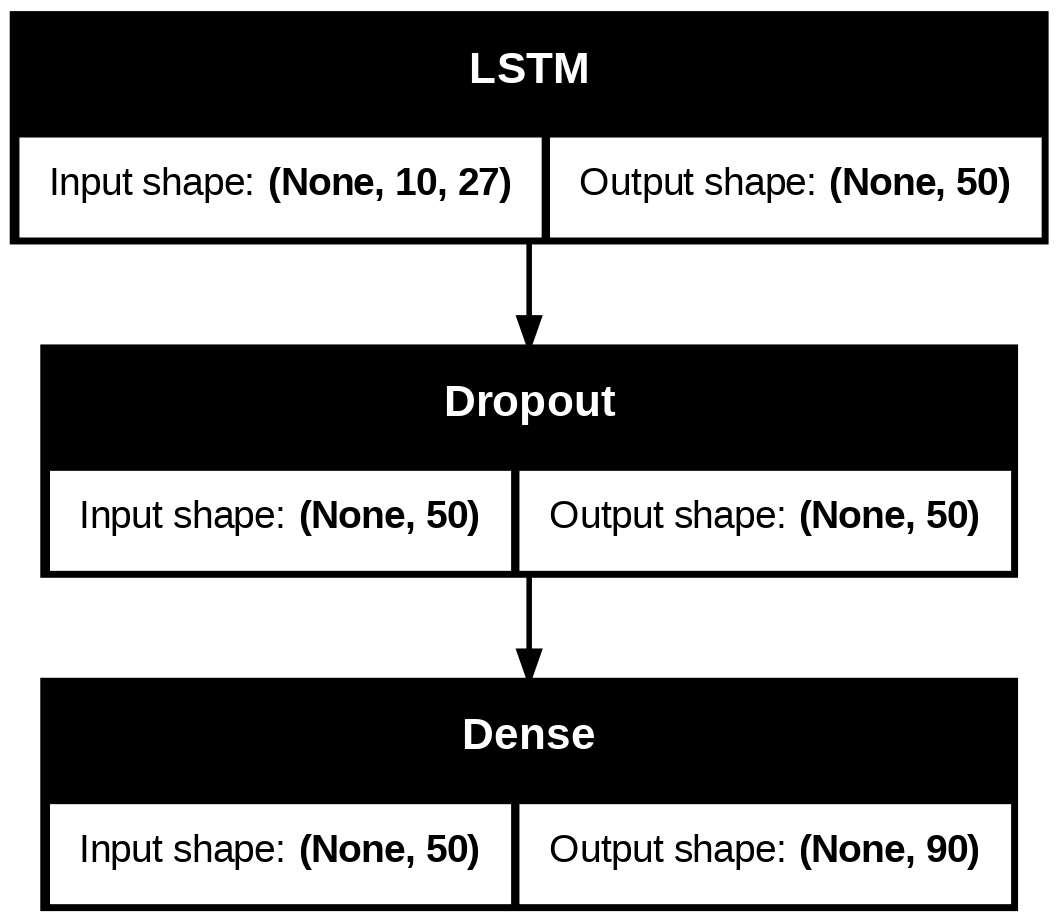

In [109]:
plot_model(model, show_shapes=True)

In [110]:

# Train the model
# Train the model with validation data
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=30,
                    verbose=1,
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5121.8799 - val_loss: 1436.7352
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3633.4944 - val_loss: 776.2281
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2373.4968 - val_loss: 761.3546
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2417.2922 - val_loss: 558.4509
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1606.3141 - val_loss: 354.2939
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1237.5636 - val_loss: 245.6043
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 843.6262 - val_loss: 231.0322
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 724.1663 - val_loss: 188.6765
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 546.4738 - val_loss: 177.0797
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 627.3234 - val_loss: 139.5126
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 501.7757 - val_loss: 134.0512
Epoch 12/30
16/16 ━━

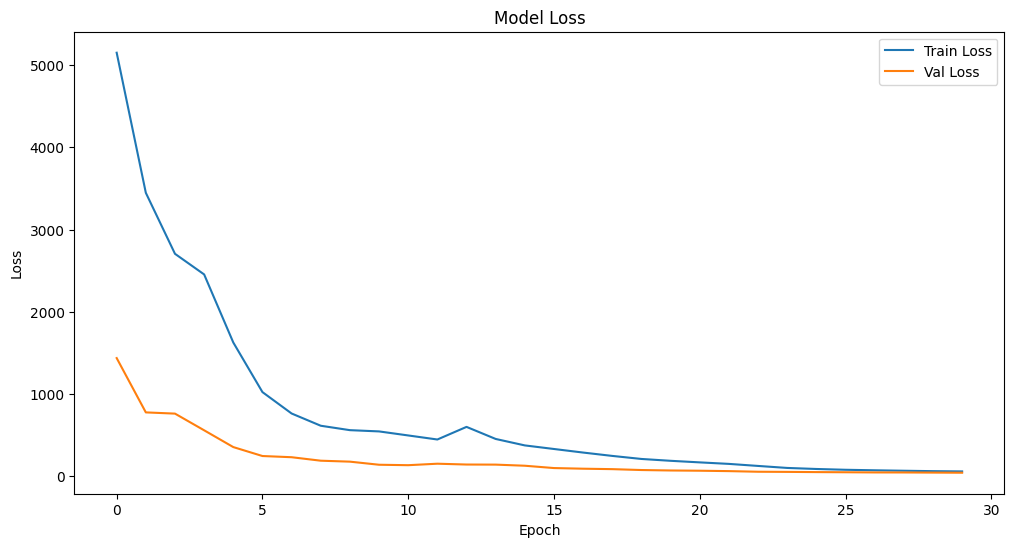

In [111]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot additional metrics if added
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


In [112]:
  # Making a prediction
yhat = model.predict(X_test, verbose=0)  # Predict future sequences
yhat = yhat.reshape(yhat.shape[0], forecast_horizon, n_output_features)
y = y.astype('int')
yhat- y_test

array([[[ 7.96000671e+00,  1.43743837e+00,  7.87064028e+00,
          4.38808584e+00,  4.29610729e+00,  7.93187428e+00,
          4.18085146e+00,  1.13699782e+00,  1.78452921e+00],
        [-4.21457916e-01, -3.98892117e+00, -5.79574227e-01,
          6.68110752e+00, -8.25568962e+00,  7.59837723e+00,
         -5.34998083e+00, -1.04491596e+01,  1.31942844e+00],
        [ 3.48697567e+00,  1.23530188e+01, -1.41095209e+00,
          1.82294595e+00, -4.81955528e-01,  6.03705025e+00,
         -6.26569152e-01, -3.09546995e+00, -5.71433306e+00],
        [ 4.28173351e+00,  3.96508646e+00,  2.80939770e+00,
         -3.35806227e+00, -6.86185741e+00, -2.83475399e-01,
          2.45152235e-01, -6.35733700e+00, -3.35399151e-01],
        [ 2.24520540e+00,  5.41173029e+00,  6.68486118e-01,
          1.03418283e+01, -1.40967636e+01,  1.08241081e+00,
          2.73221874e+00, -4.85977936e+00, -2.70328188e+00],
        [ 7.18421602e+00,  4.22055244e+00,  7.26222992e-04,
          5.11750937e+00, -1.099780

In [113]:
yhat.shape

(10, 10, 9)

In [114]:
y_test.shape

(10, 10, 9)

In [115]:
yhat = yhat.astype('int32')
y_test = y_test.astype('int32')


Combined shape: (10, 10, 18)
Mean Squared Error: 0.17210074149680027
Mean Absolute Error: 0.3428900351175751


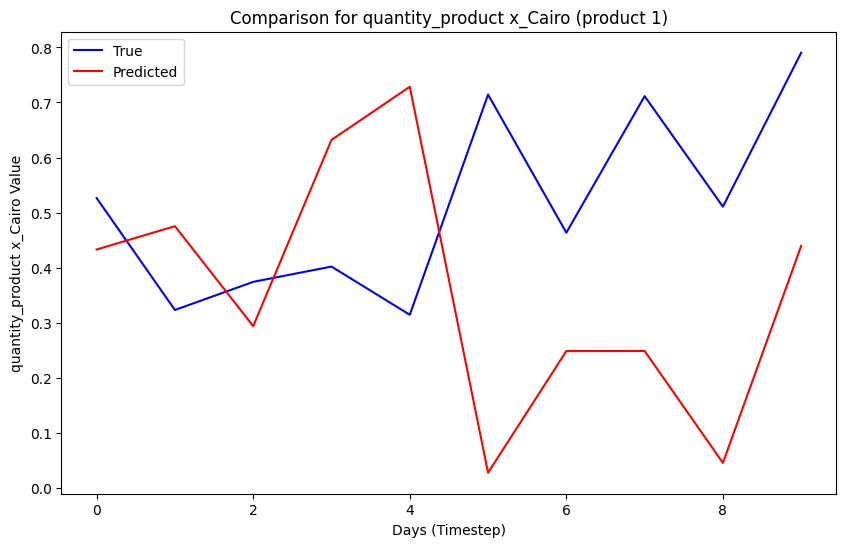

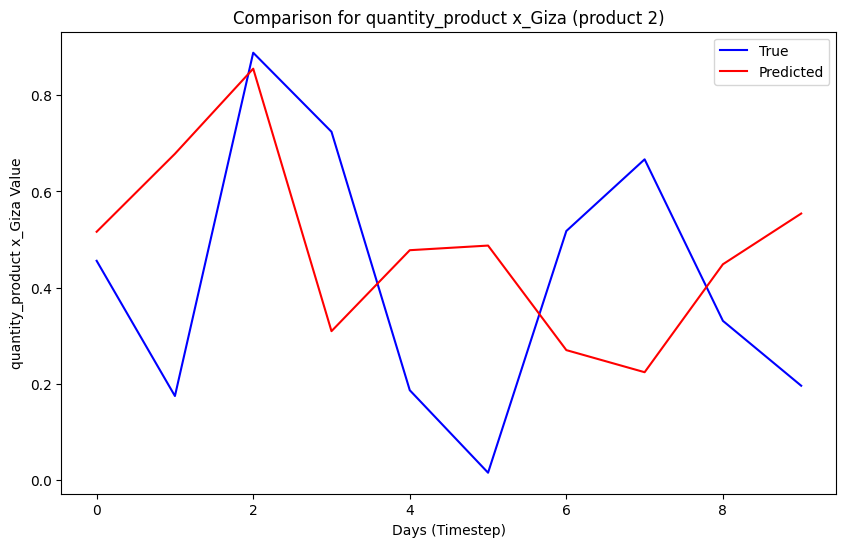

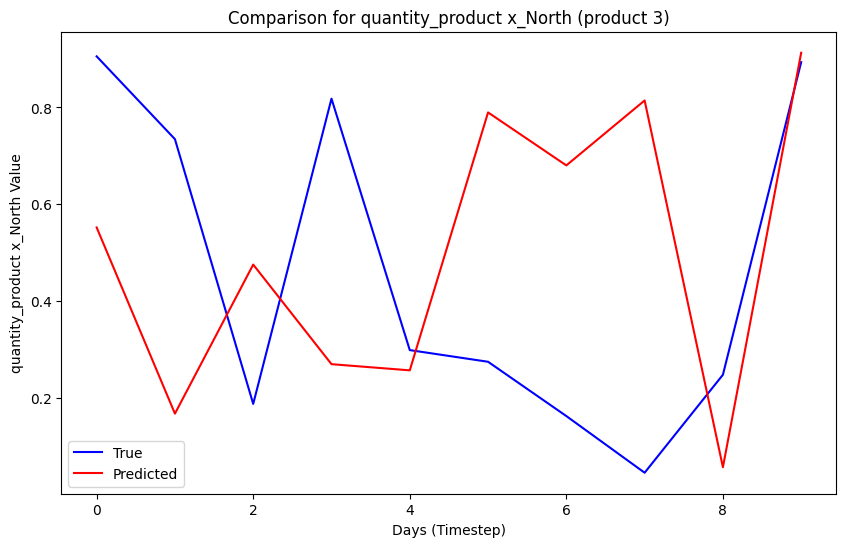

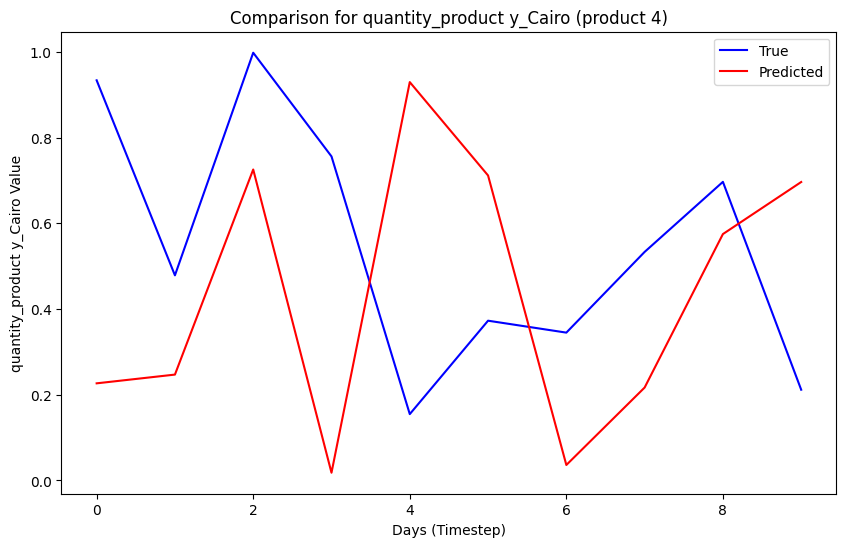

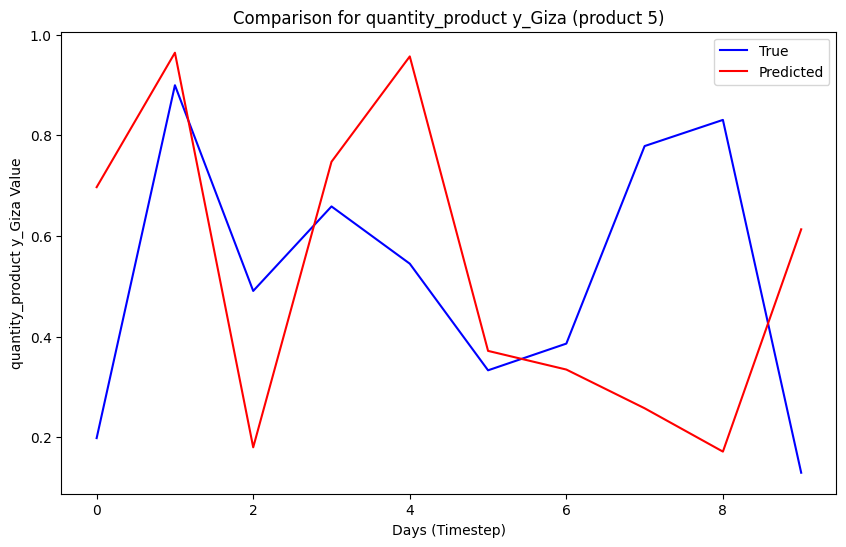

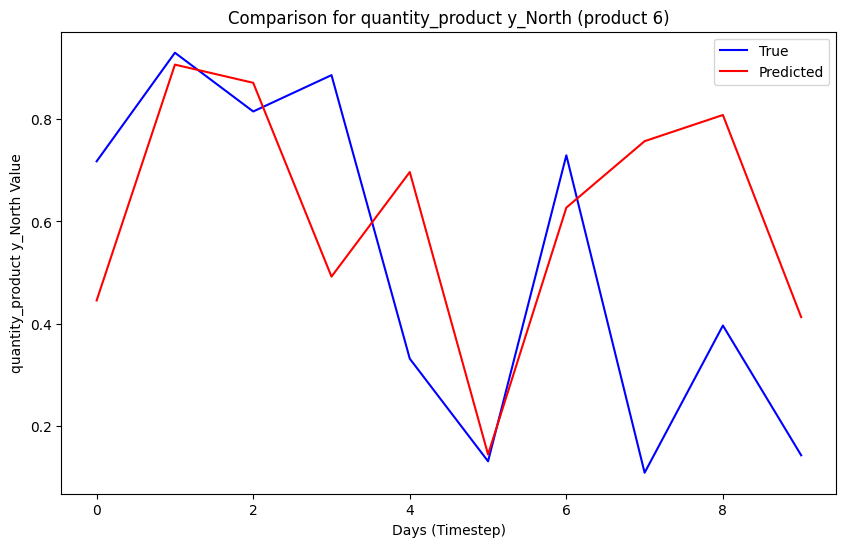

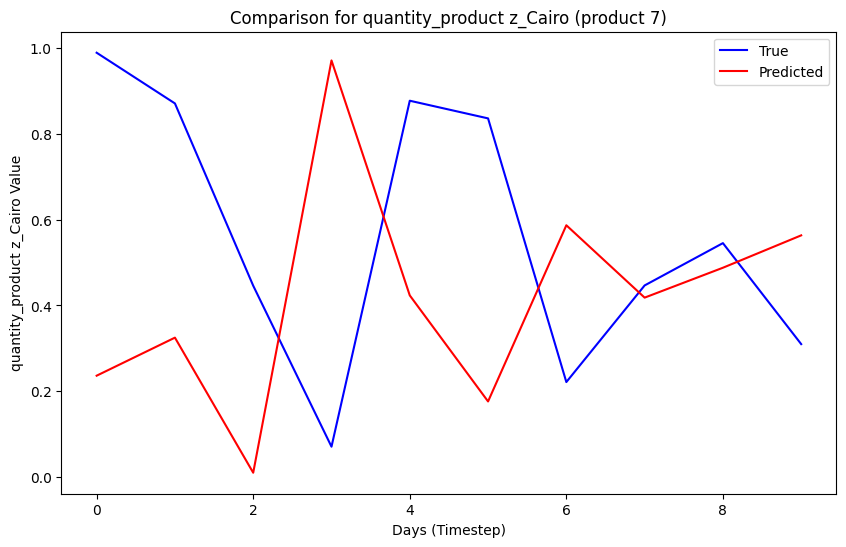

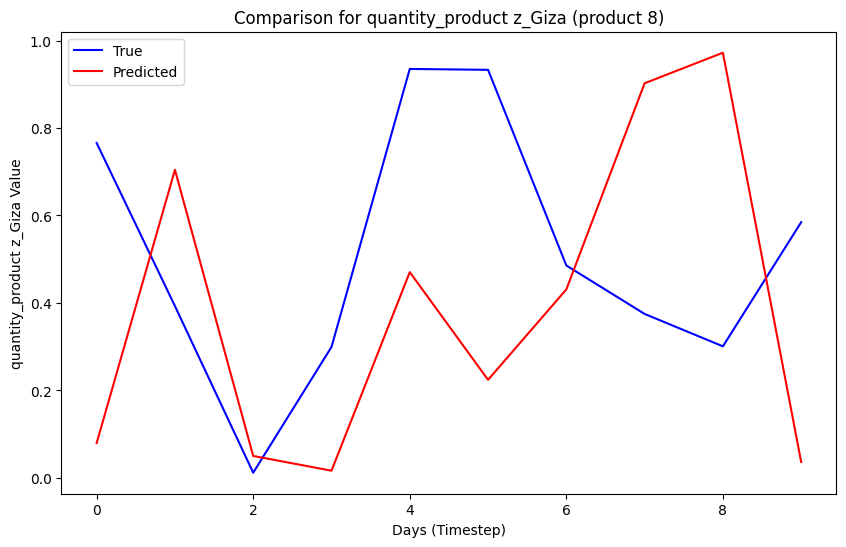

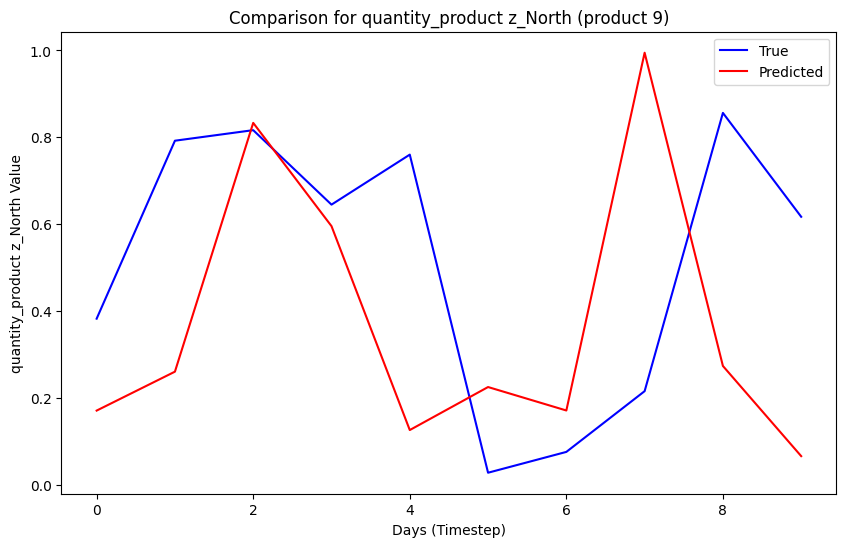

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample shape: (samples, timesteps, features)
y_test = np.random.rand(10, 10, 9)  # Actual values for 10 samples, 10 days, 9 products
y_pred = np.random.rand(10, 10, 9)  # Predicted values for 10 samples, 10 days, 9 products

# List of product names
product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'

]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Mean Squared Error (MSE) for all samples, timesteps, and products
mse = mean_squared_error(y_test.reshape(-1, y_test.shape[-1]),
                         y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Squared Error: {mse}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]),
                          y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Absolute Error: {mae}")

# 4. Visualize the comparison for each product over time (for one sample, for simplicity)
sample_idx = 0  # You can loop through other samples if needed
timesteps = y_test.shape[1]
products = y_test.shape[2]

for product_idx in range(products):
    plt.figure(figsize=(10, 6))

    # Plot True values
    plt.plot(range(timesteps), y_test[sample_idx, :, product_idx], label='True', color='blue')

    # Plot Predicted values
    plt.plot(range(timesteps), y_pred[sample_idx, :, product_idx], label='Predicted', color='red')

    plt.title(f"Comparison for {product_names[product_idx]} (product {product_idx + 1})")
    plt.xlabel('Days (Timestep)')
    plt.ylabel(f'{product_names[product_idx]} Value')
    plt.legend()
    plt.show()
